## Evaluation of UTOPIA's performance in predicting MPs size dristributionsusing the monaco Monte Carlo framework 
#### (https://monaco.readthedocs.io/en/latest/)

With this script we preform an evaluation of UTOPIA's size distribution predictive capacity by comparing predicted size distributions in targeted compartmanes aginst observed MPs size distributions reported in the compilation of published datasets by Kooi et al.

### Import the necessary libraries

In [1]:
from utopia.monte_carlo.montecarlo_analysis_paper import run_mc_analysis_paper, set_emission, sim_to_dataframe, reshape_mc_results
from utopia.monte_carlo.monte_carlo_helpers import *
from utopia.utopia import utopiaModel
import numpy as np
import scipy.stats as st
import pandas as pd

c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:18: UserWarning: Consider installing numba for better performance
  warn("Consider installing numba for better performance", UserWarning)


### Load the UTOPIA's default configuration parameters 

In [2]:
data_data = utopiaModel.load_json_file("data/default_data.json")
config_data = utopiaModel.load_json_file("data/default_config.json")


### Define the parameter distributions for the Monte Carlo simulation.


In [3]:
# To reproduce Rakesh results, use these settings:

# Plastic density (mpdensity): [900, 1100, 1500] kg/m³ 
# Fragmentation style (FI): [0, 0.3, 0.5, 0.7, 1.0] - ranging from more erosive to more explosive fragmentation 
# Discorporation half time (thalf_deg): [316,1000,10000, 31600, 100000] days 
# Fragmentation timescale (thalf_frag): [10, 31.6, 100, 316] days

param_distributions = {
    "MPdensity_kg_m3": ("rv_discrete", {"values": ([900, 1100, 1500]        
        , [1/3, 1/3, 1/3])}),
    "FI": ("rv_discrete", {"values": ([0, 0.3, 0.5, 0.7, 1.0]        
        , [0.2, 0.2, 0.2, 0.2, 0.2])}),
    "t_half_deg_free": ("rv_discrete", {"values": ([316,1000,10000, 31600, 100000]        
        , [0.2, 0.2, 0.2, 0.2, 0.2])}),
    "t_frag_gen_FreeSurfaceWater": ("rv_discrete", {"values": ([10, 31.6, 100, 316]        
        , [1/4, 1/4, 1/4, 1/4])})
}

In [4]:

# Recent studies have challenged the density of biofilm used here (1388 kg m-3) as being too high. see e.g. # https://doi.org/10.1186/s43591-024-00098-2 
# Consider testing chnages in biofouling density

In [4]:
# Set emission scenarios to run that are compatible for comparison with observations data from Kooi et al.

##############################################
# DEFINE ARTICLE -> EMISSION SCENARIOS
##############################################

overlay_emission_scenarios = {
    "Sea Sediment | Bergmann":["Ocean_Surface_Water","Coast_Surface_Water","Coast_Column_Water"],
    "Sea Surface all | Cai":["Surface_Freshwater","Coast_Surface_Water","Impacted_Soil_Surface"],
    "Sea Surface Fragments | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Sea Surface Fibers | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Fragments in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fragments in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Erni-Cassola":["Coast_Surface_Water","Impacted_Soil_Surface"],
    "Fresh water sediments | Imhof":["Surface_Freshwater","Impacted_Soil_Surface"],
    "Sea Surface all | Isobe L1":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L2":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L3":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L4":["Surface_Freshwater","Coast_Surface_Water"],
    "FP all | Scheurer":["Impacted_Soil_Surface"],
    "Sea Surface Fragments | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface Fibers | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Zhang":["Coast_Surface_Water","Surface_Freshwater"]}
    
    
    
    
# DEFINE ARTICLE->COMPARTMENTS MAPPING
#############################################
overlay_compartments_mapping = {
    "Sea Sediment | Bergmann": ["Sediment_Coast", "Sediment_Ocean"],
    "Sea Surface all | Cai": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fragments | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fragments in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fibers in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fragments in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil","Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Fibers in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil",
    "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Sea Surface all | Erni-Cassola": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fresh water sediments | Imhof": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Sea Surface all | Isobe L1": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L2": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L3": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe L4": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "FP all | Scheurer": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface Fragments | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Zhang": ["Coast_Surface_Water", "Ocean_Surface_Water"]
}

# NOTE! Maybe the mapping for the FP all | Scheurer study has to be revisited. Samples were collected in floodplain soils, so the impacted_soil_surface compartment might be more appropriate. Since the model does not simulate floodplain soils as a separate compartment.?

In [6]:
# Set emission scenarios according to the mapping defined above to the run the model for each parameter combination using the Monte Carlo framework and perform the comparison with the observed data according to mapping.

In [5]:
art= "Sea Surface Fibers | Song"
print(f"Running Monte Carlo analysis for article: {art}")


Running Monte Carlo analysis for article: Sea Surface Fibers | Song


In [6]:
MC_simulations_results = {"Article": art}
for comp in overlay_emission_scenarios[art]:
    # Set emissions to that compartment and include it in base_data file
    data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
    #Run Monte Carlo analysis for each emission scenario
    sim= run_mc_analysis_paper(
    base_config=config_data,
    base_data=data_data,
    param_distributions=param_distributions,
    n_cases=20,art=art,
)
    
    # Convert sim results to dataframe
    df_MC_results = sim_to_dataframe(sim)
    
    #Transform dataframe to long format for easier processing
    input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","residence_time_mass","residence_time_number","persistence_mass","persistence_number"]
    compartments= overlay_compartments_mapping[art]
    dataset_name=art
    emission_comp=comp
    tidy=reshape_mc_results(df_MC_results, compartments, input_params, dataset_name, emission_comp)

    

Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done


Running cases:   0%|          | 0/20 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  50%|█████     | 10/20 [00:22<00:22,  2.25s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
R

Simulation complete! Runtime: 0:00:46.346569
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/20 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  50%|█████     | 10/20 [00:23<00:23,  2.33s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Simulation complete! Runtime: 0:00:46.513602


In [7]:
tidy

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
0,0,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,NaN,NaN,1500.0,0.0,31600.0,10.0,0.000008,4.937800,3.243785,3.871297e+06
1,0,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,NaN,NaN,1500.0,0.0,31600.0,10.0,0.000008,4.937800,3.243785,3.871297e+06
2,1,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.413501,-0.914820,-0.983563,-1.0,True,900.0,0.7,1000.0,100.0,0.003927,0.226905,0.003927,2.113796e+04
3,1,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,NaN,NaN,900.0,0.7,1000.0,100.0,0.003927,0.226905,0.003927,2.113796e+04
4,2,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,2.339902,-60.315451,-2.773640,-1.0,True,1100.0,0.3,100000.0,31.6,0.000029,8.351796,13.964149,1.334757e+07
5,2,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,3.982593,-176.625995,-4.255667,-1.0,True,1100.0,0.3,100000.0,31.6,0.000029,8.351796,13.964149,1.334757e+07
6,3,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,NaN,NaN,1100.0,1.0,316.0,316.0,0.000006,0.000006,0.012786,1.326006e-02
7,3,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,NaN,NaN,1100.0,1.0,316.0,316.0,0.000006,0.000006,0.012786,1.326006e-02
8,4,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,NaN,NaN,1100.0,0.3,1000.0,316.0,0.000006,0.449368,0.042499,4.050801e+04
9,4,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,NaN,NaN,1100.0,0.3,1000.0,316.0,0.000006,0.449368,0.042499,4.050801e+04


In [8]:
# Sort ascending by RMSE (best fits first)
results_sorted_art = tidy.sort_values("RMSE", ascending=True)

# Keep e.g. top 20 best-fitting combinations
top_results_art = results_sorted_art.head(10)


In [9]:
top_results_art

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
12,6,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.271818,0.172567,-1.207233,-1.0,True,900.0,0.3,316.0,100.0,0.001285,0.213536,0.001285,6.644165e+03
2,1,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.413501,-0.914820,-0.983563,-1.0,True,900.0,0.7,1000.0,100.0,0.003927,0.226905,0.003927,2.113796e+04
13,6,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,0.548535,-2.369641,-1.886179,-1.0,True,900.0,0.3,316.0,100.0,0.001285,0.213536,0.001285,6.644165e+03
28,14,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,0.766734,-5.583606,-0.450385,-1.0,True,900.0,0.5,10000.0,316.0,0.029297,0.323665,0.029305,2.055593e+05
22,11,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.747943,-33.216013,-2.358854,-1.0,True,1500.0,0.7,31600.0,100.0,0.000007,5.055093,3.084787,3.887954e+06
4,2,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,2.339902,-60.315451,-2.773640,-1.0,True,1100.0,0.3,100000.0,31.6,0.000029,8.351796,13.964149,1.334757e+07
14,7,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,2.664358,-78.498641,-3.099658,-1.0,True,1500.0,0.5,100000.0,10.0,0.000012,8.107236,14.465450,1.330043e+07
31,15,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,3.196703,-113.440348,-3.442912,-1.0,True,1500.0,0.7,1000.0,31.6,0.000003,0.449542,0.042621,4.060868e+04
23,11,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,3.362112,-125.589900,-3.821837,-1.0,True,1500.0,0.7,31600.0,100.0,0.000007,5.055093,3.084787,3.887954e+06
27,13,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,3.623328,-146.024537,-3.779597,-1.0,True,1100.0,0.7,316.0,10.0,0.000006,0.278642,0.012859,8.860261e+03


In [ ]:
from utopia.utopia import utopiaModel
from utopia.results_processing.process_results import *
from utopia.monte_carlo.montecarlo_analysis_paper import extract_log_rel_abundance, plot_obs_vs_model_with_metrics
def run_and_plot_top_results(top_results):
    observed_file = "../src/utopia/data/observed_data_long.xlsx"

    observed_df = pd.read_excel(observed_file)

    observed_df = observed_df.rename(
        columns={
            "dataset identifier": "Dataset",
            "Article name": "Article",
            "log‑transformed size": "log_Size",
            "log‑transformed abundance": "log_Abundance",
            }
        )
    for i in range(len(top_results)):
        art = top_results.iloc[i]["Observed_dataset"]
        comp_E = top_results.iloc[i]["Emission_Compartment"]
        comp_T= top_results.iloc[i]["Target_Compartment"]
        new_data = data_data.copy()
        new_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp_E, "e", 100)
        new_data["MPdensity_kg_m3"]= top_results.iloc[i]["MPdensity_kg_m3"]
        new_data["FI"]= top_results.iloc[i]["FI"]
        new_data["t_half_deg_free"]= top_results.iloc[i]["t_half_deg_free"]
        new_data["t_frag_gen_FreeSurfaceWater"]= top_results.iloc[i]["t_frag_gen_FreeSurfaceWater"]
        model = utopiaModel(config=config_data, data=new_data)
        model.run()
        processor = ResultsProcessor(model)
        processor.estimate_flows()
        processor.generate_flows_dict()
        processor.process_results() 
        processor.extract_results_by_compartment()
        df = processor.results_by_comp
        df2 = processor.Results_extended
        processor.estimate_exposure_indicators()
        model_df=df2.copy()
        excluded_sizes = [0.5, 5]
        filtered_Results = model_df[
            ~model_df["Size_Fraction_um"].isin(excluded_sizes)
        ]
        rel_abun = extract_log_rel_abundance(
            filtered_Results,
            compartment=comp,
            value_col="number_of_particles",
    )
        
        input_dict={"MPdensity_kg_m3":new_data["MPdensity_kg_m3"],"FI":new_data["FI"],"t_half_deg_free":new_data["t_half_deg_free"],"t_frag_gen_FreeSurfaceWater":new_data["t_frag_gen_FreeSurfaceWater"]}
        
        obs_subset = observed_df[observed_df["Article"] == art]
        
        plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp_T, art=art,input_dict=input_dict)

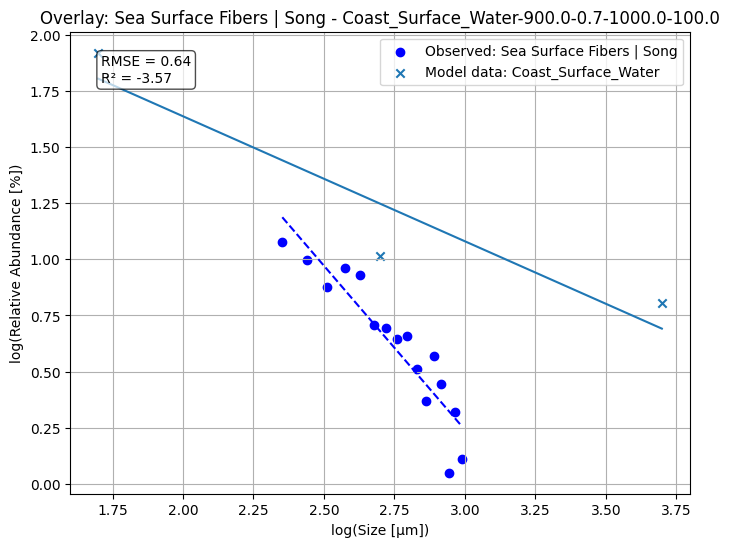

In [11]:
run_and_plot_top_results(top_results_art)

In [55]:
# Run the Monte Carlo analysis with the specified parameters distributions and number of cases for specified emission scenarios related to the obsserved data from articles in the list.

all_results = [] 

# Run the Monte Carlo analysis for each article and emission scenario
for art in overlay_emission_scenarios: 
    for comp in overlay_emission_scenarios[art]:
        # Set emissions to that compartment and include it in base_data file
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
        # Run Monte Carlo analysis for each emission scenario
        sim= run_mc_analysis_paper(
        base_config=config_data,
        base_data=data_data,
        param_distributions=param_distributions,
        n_cases=10,art=art,
    )
        # Convert sim results to dataframe
        df_MC_results = sim_to_dataframe(sim)
        
        #Transform dataframe to long format for easier processing
        input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","residence_time_mass","residence_time_number","persistence_mass","persistence_number"]
        compartments= overlay_compartments_mapping[art]
        dataset_name=art
        emission_comp=comp
        tidy=reshape_mc_results(df_MC_results, compartments, input_params, dataset_name, emission_comp)
        
        all_results.append(tidy)

results_df = pd.concat(all_results, ignore_index=True)

Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... 

Done
Generating cases... Done


Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 1/10 [00:02<00:19,  2.11s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Ru

Simulation complete! Runtime: 0:00:20.436214
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 1/10 [00:02<00:20,  2.32s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
R

Simulation complete! Runtime: 0:00:21.031251
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 1/10 [00:02<00:18,  2.03s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
R

Simulation complete! Runtime: 0:00:20.886704
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 3333.84 cases/s]

Simulation complete! Runtime: 0:00:21.033480
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 2588.44 cases/s]

Simulation complete! Runtime: 0:00:25.638688
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:29.200892
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 3332.78 cases/s]

Simulation complete! Runtime: 0:00:28.275593
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:27.207426
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:21.561226
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:20.385859
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 1271.23 cases/s]

Simulation complete! Runtime: 0:00:20.122165
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 828.78 cases/s]

Simulation complete! Runtime: 0:00:20.511053
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 1245.12 cases/s]

Simulation complete! Runtime: 0:00:20.459314
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:20.343290
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\

Simulation complete! Runtime: 0:00:20.706539
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\

Simulation complete! Runtime: 0:00:21.200586
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\

Simulation complete! Runtime: 0:00:20.955683
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\

Simulation complete! Runtime: 0:00:20.964123
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 685.18 cases/s]

Simulation complete! Runtime: 0:00:21.785627
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 666.30 cases/s]

Simulation complete! Runtime: 0:00:23.175814
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 547.33 cases/s]

Simulation complete! Runtime: 0:00:19.942778
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:20.053708
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 1446.16 cases/s]

Simulation complete! Runtime: 0:00:22.407765
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 7762.92 cases/s]

Simulation complete! Runtime: 0:00:19.690766
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 3334.64 cases/s]

Simulation complete! Runtime: 0:00:20.239730
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 1426.83 cases/s]

Simulation complete! Runtime: 0:00:22.657173
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 5014.11 cases/s] 

Simulation complete! Runtime: 0:00:22.295071
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 3146.04 cases/s]

Simulation complete! Runtime: 0:00:20.382318
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 3985.47 cases/s]

Simulation complete! Runtime: 0:00:20.552346
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 9908.58 cases/s]

Simulation complete! Runtime: 0:00:20.763505
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 2294.85 cases/s]

Simulation complete! Runtime: 0:00:19.859183
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 3334.10 cases/s]

Simulation complete! Runtime: 0:00:20.289705
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 2147.18 cases/s]

Simulation complete! Runtime: 0:00:20.549724
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 3043.32 cases/s]

Simulation complete! Runtime: 0:00:26.516144
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 2418.02 cases/s]

Simulation complete! Runtime: 0:00:19.456350
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 2389.92 cases/s]

Simulation complete! Runtime: 0:00:19.313661
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 10/10 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   0%|          | 0/10 [00:00<?, ? cases/s]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 10/10 [00:00<00:00, 2499.88 cases/s]

Simulation complete! Runtime: 0:00:19.117569


In [84]:
results_df[results_df["Observed_dataset"]=="Sea Surface Fibers | Song"]

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
780,0,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,NaN,NaN,NaN,0.866025,False,1500.0,0.0,31600.0,10.0,80.512868,511.920637,119.997140,6.243379e+07
781,0,Sea Surface Fibers | Song,Impacted_Soil_Surface,Ocean_Surface_Water,NaN,NaN,NaN,0.866025,False,1500.0,0.0,31600.0,10.0,80.512868,511.920637,119.997140,6.243379e+07
782,1,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,3.421463,-130.098714,-2.925310,-1.000000,True,900.0,0.7,1000.0,100.0,0.205755,498.054536,0.206257,1.905018e+06
783,1,Sea Surface Fibers | Song,Impacted_Soil_Surface,Ocean_Surface_Water,3.194494,-113.282254,-2.756123,-1.000000,True,900.0,0.7,1000.0,100.0,0.205755,498.054536,0.206257,1.905018e+06
784,2,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,5.797662,-375.426700,-4.528368,-1.000000,True,1100.0,0.3,100000.0,31.6,76.737792,508.419552,118.998492,1.945231e+08
785,2,Sea Surface Fibers | Song,Impacted_Soil_Surface,Ocean_Surface_Water,5.711457,-364.315800,-4.460143,-1.000000,True,1100.0,0.3,100000.0,31.6,76.737792,508.419552,118.998492,1.945231e+08
786,3,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,3.953323,-174.024636,-2.956750,-1.000000,True,1100.0,1.0,316.0,316.0,0.001290,442.509522,0.001291,2.813459e+03
787,3,Sea Surface Fibers | Song,Impacted_Soil_Surface,Ocean_Surface_Water,3.860556,-165.906918,-2.887563,-1.000000,True,1100.0,1.0,316.0,316.0,0.001290,442.509522,0.001291,2.813459e+03
788,4,Sea Surface Fibers | Song,Impacted_Soil_Surface,Coast_Surface_Water,5.644932,-355.855206,-3.925307,-1.000000,True,1100.0,0.3,1000.0,316.0,0.114932,503.546805,0.115172,1.936765e+06
789,4,Sea Surface Fibers | Song,Impacted_Soil_Surface,Ocean_Surface_Water,5.554076,-344.460387,-3.855762,-1.000000,True,1100.0,0.3,1000.0,316.0,0.114932,503.546805,0.115172,1.936765e+06


In [57]:
# Sort ascending by RMSE (best fits first)
results_sorted = results_df.sort_values("RMSE", ascending=True)

# Keep e.g. top 20 best-fitting combinations
top_results = results_sorted.head(20)


In [59]:

top_results

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
122,1,Sea Surface Fragments | Enders,Ocean_Surface_Water,Coast_Surface_Water,0.511755,0.103661,-0.799615,-1.0,True,900.0,0.7,1000.0,100.0,0.004350,1.192428,0.004350,1.368210e+04
143,1,Sea Surface Fragments | Enders,Coast_Surface_Water,Ocean_Surface_Water,0.512296,0.101765,-0.810777,-1.0,True,900.0,0.7,1000.0,100.0,0.005614,16.278725,0.005615,2.950695e+04
123,1,Sea Surface Fragments | Enders,Ocean_Surface_Water,Ocean_Surface_Water,0.583388,-0.164830,-0.462513,-1.0,True,900.0,0.7,1000.0,100.0,0.004350,1.192428,0.004350,1.368210e+04
27,3,Sea Sediment | Bergmann,Coast_Surface_Water,Sediment_Ocean,0.663460,-6.210978,-0.832893,-1.0,True,1100.0,1.0,316.0,316.0,0.124254,0.295077,0.124769,2.979176e-01
47,3,Sea Sediment | Bergmann,Coast_Column_Water,Sediment_Ocean,0.672188,-6.401955,-0.858404,-1.0,True,1100.0,1.0,316.0,316.0,0.124333,0.295266,0.124846,2.981024e-01
523,1,Fresh water sediments | Imhof,Surface_Freshwater,Surface_Freshwater,0.731096,-4.147099,-0.556625,-1.0,True,900.0,0.7,1000.0,100.0,0.003927,0.226905,0.003927,2.113796e+04
483,1,Sea Surface all | Erni-Cassola,Coast_Surface_Water,Ocean_Surface_Water,0.744659,-2.865824,-0.810777,-1.0,True,900.0,0.7,1000.0,100.0,0.005614,16.278725,0.005615,2.950695e+04
510,5,Sea Surface all | Erni-Cassola,Impacted_Soil_Surface,Coast_Surface_Water,0.829015,-3.791285,-2.950553,-1.0,True,900.0,1.0,31600.0,31.6,19.305180,521.245710,21.902053,2.147542e+07
762,1,Sea Surface Fragments | Song,Surface_Freshwater,Coast_Surface_Water,1.119696,-1.333057,-0.983563,-1.0,True,900.0,0.7,1000.0,100.0,0.003927,0.226905,0.003927,2.113796e+04
503,1,Sea Surface all | Erni-Cassola,Impacted_Soil_Surface,Ocean_Surface_Water,1.131237,-7.921442,-2.756123,-1.0,True,900.0,0.7,1000.0,100.0,0.205755,498.054536,0.206257,1.905018e+06


In [60]:
def plot_obs_vs_model_with_metrics(obs_df, model_df, compartment, art,input_dict):
    """ Plot observed vs modeled log-abundance by size with regression and metrics.
    
    Parameters
    ----------
    obs_df : pd.DataFrame
        Observed dataset with columns x_col and y_obs_col
    model_df : pd.DataFrame
        Modeled dataset with columns x_col and y_mod_col
    compartment : str
        Name of the compartment for title
    art : str
        Name of the article for title"""
    
    x_obs_all = obs_df["log_Size"].astype(float).values
    y_obs_all = obs_df["log_Abundance"].astype(float).values

    x_mod_all = model_df["log_size"].values
    y_mod_all = model_df["log_rel_abundance"].values

    # Fit powerlaw on observed dataset 
    if len(x_obs_all) >= 2:
        slope_obs, intercept_obs = np.polyfit(x_obs_all, y_obs_all, 1)
        x_fit_obs = np.linspace(x_obs_all.min(), x_obs_all.max(), 100)
        y_fit_obs = slope_obs * x_fit_obs + intercept_obs
        
        plt.figure(figsize=(8, 6))
        plt.scatter(x_obs_all, y_obs_all, color='blue', marker='o',
                    label=f"Observed: {art}")
        if x_fit_obs is not None:
            plt.plot(x_fit_obs, y_fit_obs, color='blue', linestyle='--',
                        label="_nolegend_")

    # Plot modelled dataset (filtered for excluded sizes)
    plt.scatter(x_mod_all, y_mod_all,marker='x', label=f"Model data: {comp}")
    slope_mod, intercept_mod = np.nan, np.nan
    if len(x_mod_all) >= 2:
        slope_mod, intercept_mod = np.polyfit(x_mod_all, y_mod_all, 1)
        x_fit_mod = np.linspace(x_mod_all.min(), x_mod_all.max(), 100)
        y_fit_mod = slope_mod*x_fit_mod + intercept_mod
        plt.plot(x_fit_mod, y_fit_mod, label="_nolegend_")

    # Compute metrics
    if len(x_obs_all) < 2 or len(x_mod_all) < 2:
        r2 = np.nan
        rmse = np.nan
        euclid_dist = np.nan
        n_points = 0
    else:
        # Intersection range
        x_min = max(x_obs_all.min(), x_mod_all.min())
        x_max = min(x_obs_all.max(), x_mod_all.max())
        mask_obs = (x_obs_all >= x_min) & (x_obs_all <= x_max)
        x_obs_filt = x_obs_all[mask_obs]
        y_obs_filt = y_obs_all[mask_obs]

        if len(x_obs_filt) < 2:
            r2 = np.nan
            rmse = np.nan
            n_points = len(x_obs_filt)
        else:
            pred_y = slope_mod*x_obs_filt + intercept_mod
            ss_res = np.sum((y_obs_filt - pred_y)**2)
            ss_tot = np.sum((y_obs_filt - y_obs_filt.mean())**2)
            r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
            rmse = np.sqrt(ss_res/len(x_obs_filt))
            n_points = len(x_obs_filt)

        if not np.isnan(slope_mod) and not np.isnan(slope_obs):
            euclid_dist = np.sqrt((slope_mod - slope_obs)**2 + (intercept_mod - intercept_obs)**2)
        else:
            euclid_dist = np.nan
    plt.xlabel("log(Size [µm])")
    plt.ylabel("log(Relative Abundance [%])")
    plt.title(
        f"Overlay: {art} - {compartment} - "
        f"{input_dict['MPdensity_kg_m3']:.0f}-"
        f"{input_dict['FI']:.2f}-"
        f"{input_dict['t_half_deg_free']:.2f}-"
        f"{input_dict['t_frag_gen_FreeSurfaceWater']:.2f}"
    )
    # Annotate metrics
    plt.text(0.05, 0.95, f"RMSE = {rmse:.2f}\nR² = {r2:.2f}", transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [61]:
from utopia.utopia import utopiaModel
from utopia.results_processing.process_results import *
from utopia.monte_carlo.montecarlo_analysis_paper import extract_log_rel_abundance, plot_obs_vs_model_with_metrics
def run_and_plot_top_results(top_results):
    observed_file = "../src/utopia/data/observed_data_long.xlsx"

    observed_df = pd.read_excel(observed_file)

    observed_df = observed_df.rename(
        columns={
            "dataset identifier": "Dataset",
            "Article name": "Article",
            "log‑transformed size": "log_Size",
            "log‑transformed abundance": "log_Abundance",
            }
        )
    for i in range(len(top_results)):
        art = top_results.iloc[i]["Observed_dataset"]
        comp_E = top_results.iloc[i]["Emission_Compartment"]
        comp_T= top_results.iloc[i]["Target_Compartment"]
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp_E, "e", 100)
        data_data["MPdensity_kg_m3"]= top_results.iloc[i]["MPdensity_kg_m3"]
        data_data["FI"]= top_results.iloc[i]["FI"]
        data_data["t_half_deg_free"]= top_results.iloc[i]["t_half_deg_free"]
        data_data["t_frag_gen_FreeSurfaceWater"]= top_results.iloc[i]["t_frag_gen_FreeSurfaceWater"]
        model = utopiaModel(config=config_data, data=data_data)
        model.run()
        processor = ResultsProcessor(model)
        processor.estimate_flows()
        processor.generate_flows_dict()
        processor.process_results() 
        processor.extract_results_by_compartment()
        df = processor.results_by_comp
        df2 = processor.Results_extended
        processor.estimate_exposure_indicators()
        model_df=df2.copy()
        excluded_sizes = [0.5, 5]
        filtered_Results = model_df[
            ~model_df["Size_Fraction_um"].isin(excluded_sizes)
        ]
        rel_abun = extract_log_rel_abundance(
            filtered_Results,
            compartment=comp,
            value_col="number_of_particles",
    )
        
        input_dict={"MPdensity_kg_m3":data_data["MPdensity_kg_m3"],"FI":data_data["FI"],"t_half_deg_free":data_data["t_half_deg_free"],"t_frag_gen_FreeSurfaceWater":data_data["t_frag_gen_FreeSurfaceWater"]}
        
        obs_subset = observed_df[observed_df["Article"] == art]
        
        plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp_T, art=art,input_dict=input_dict)

From top results run model and plot overlays with observed data

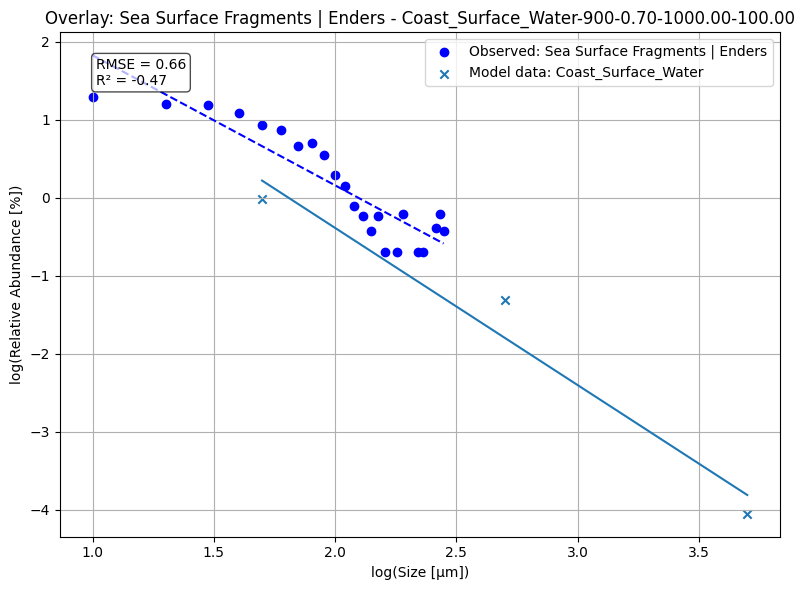

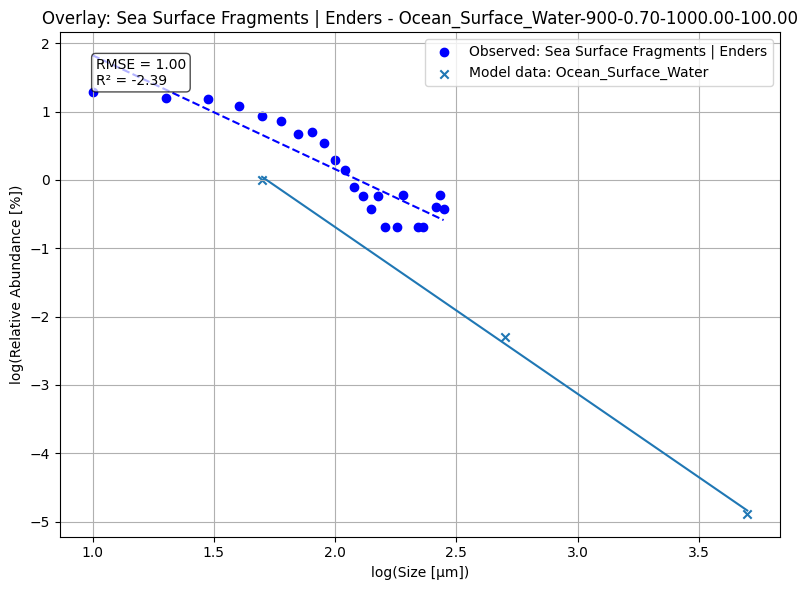

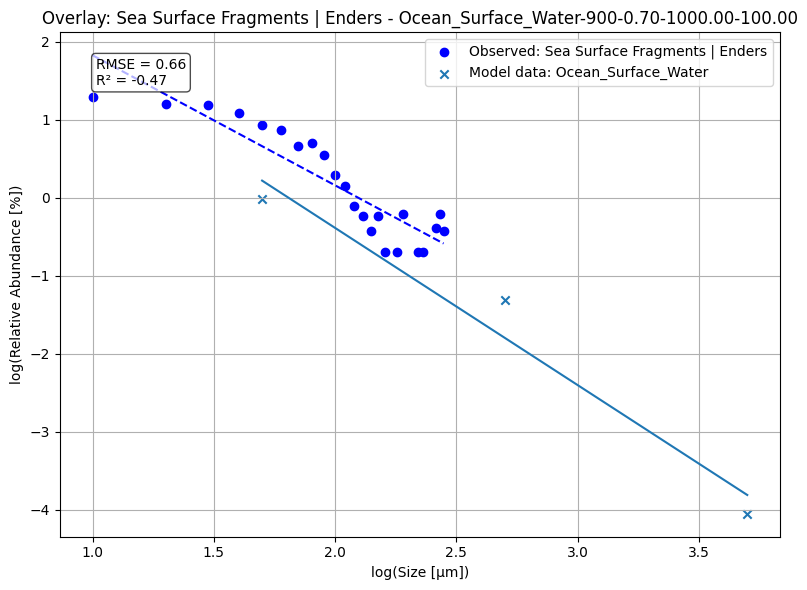

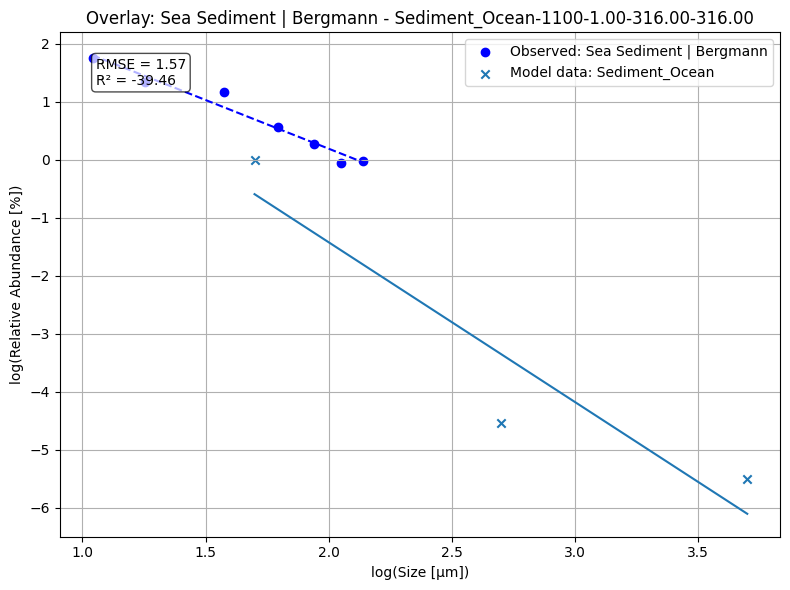

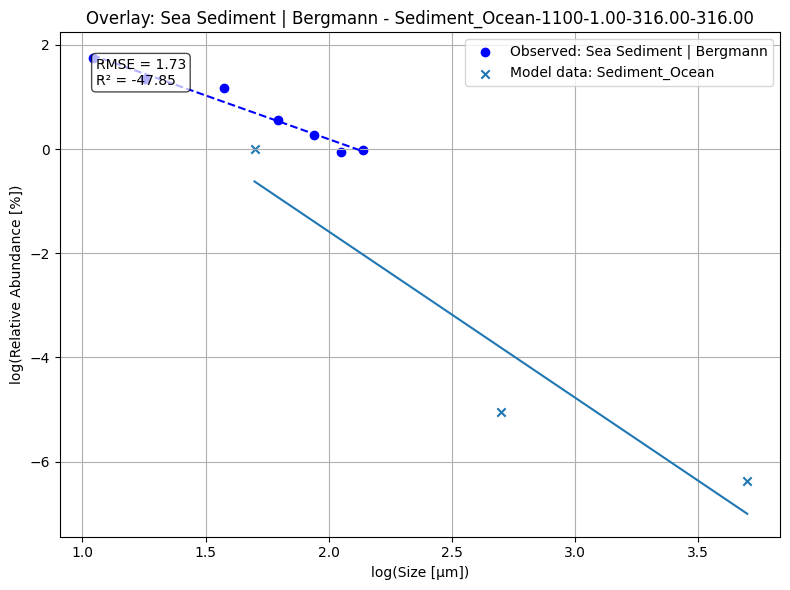

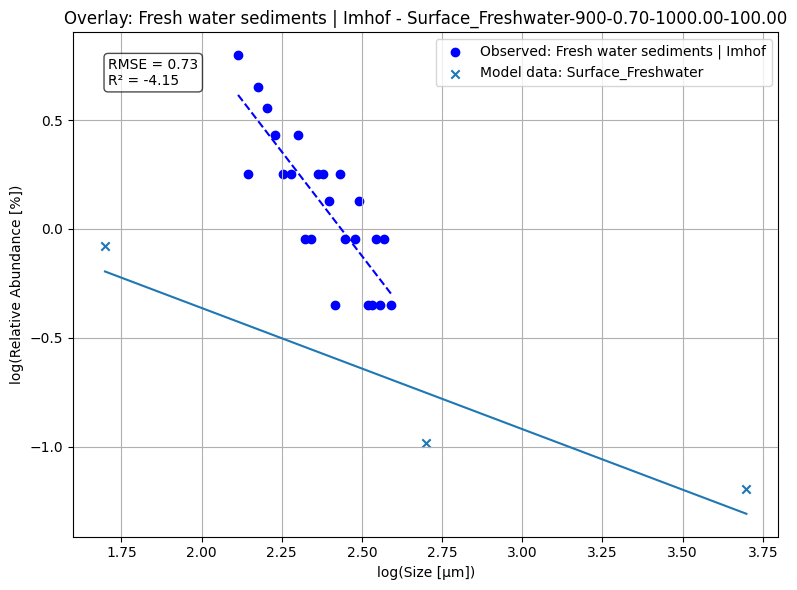

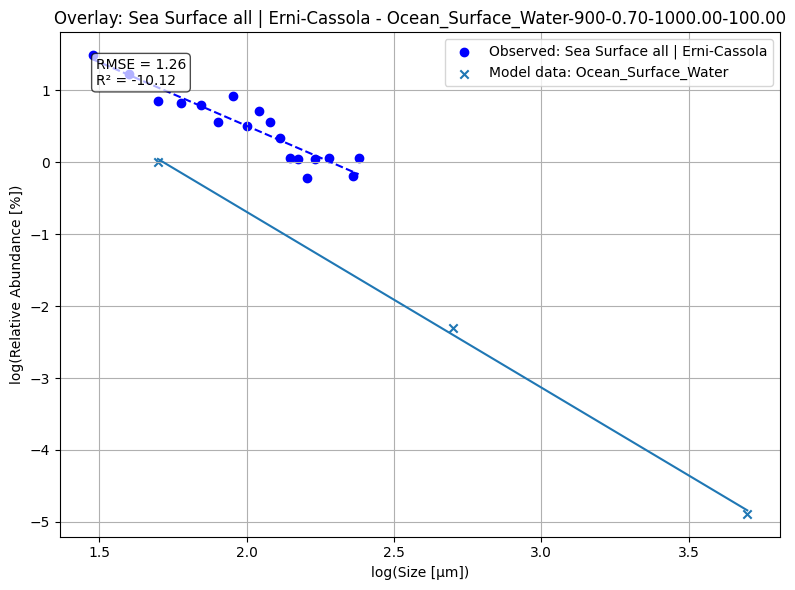

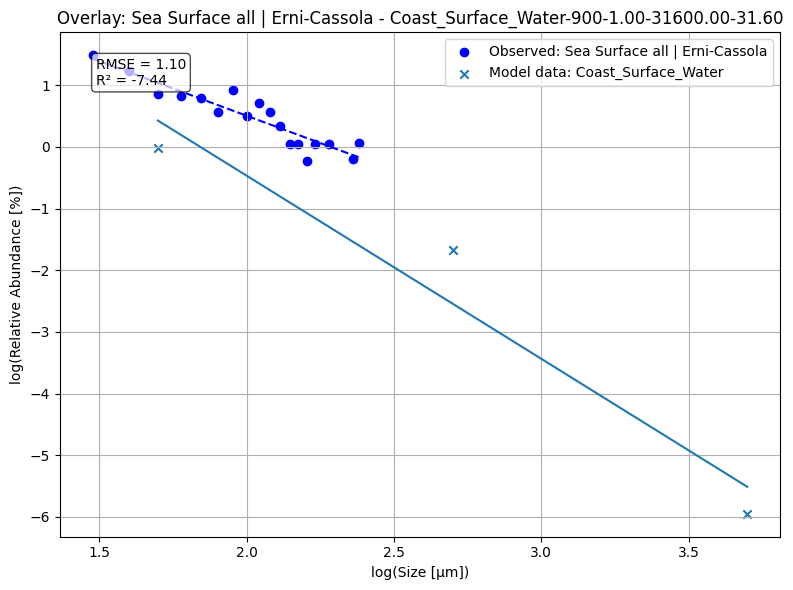

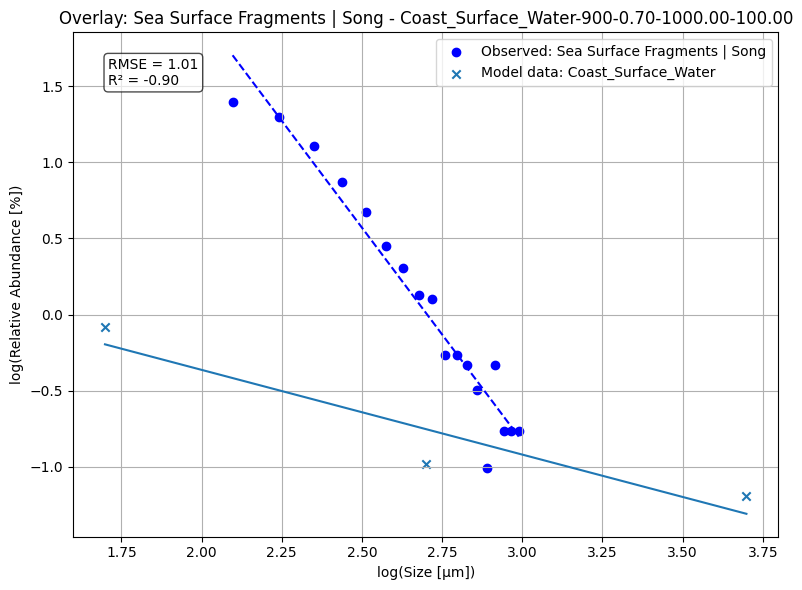

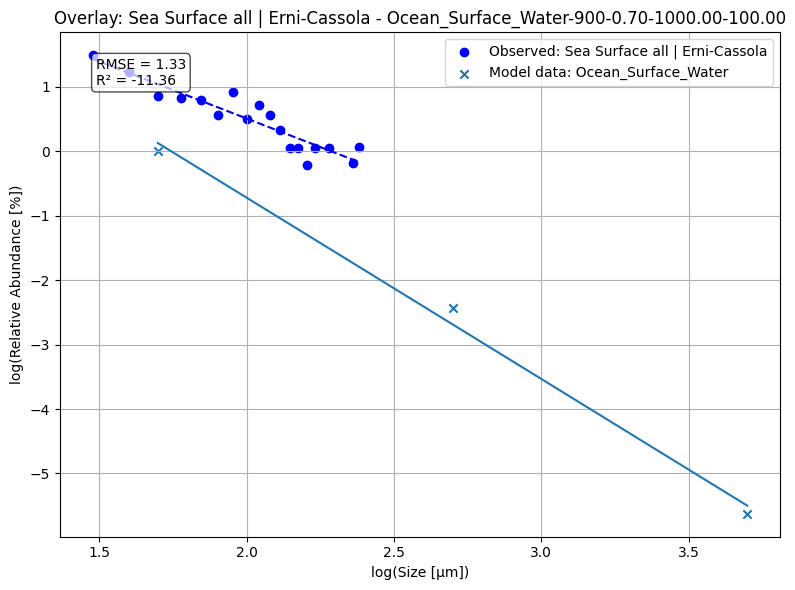

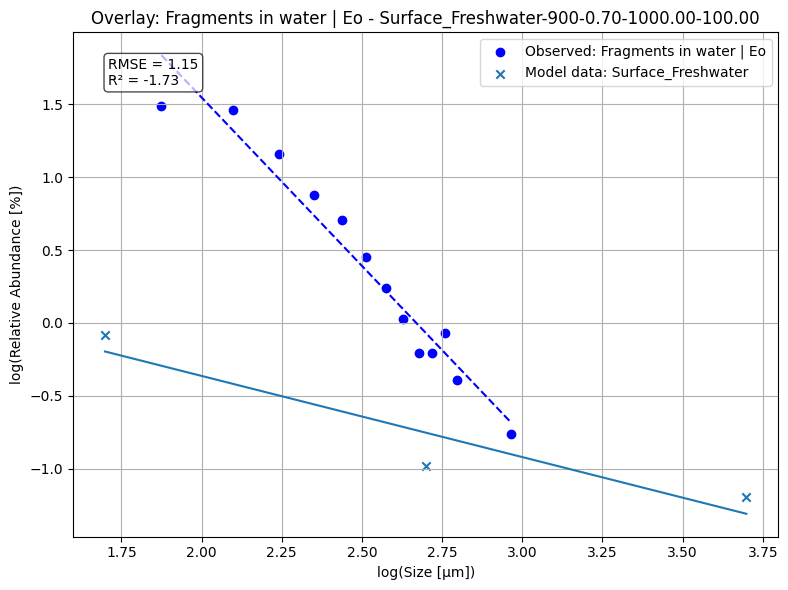

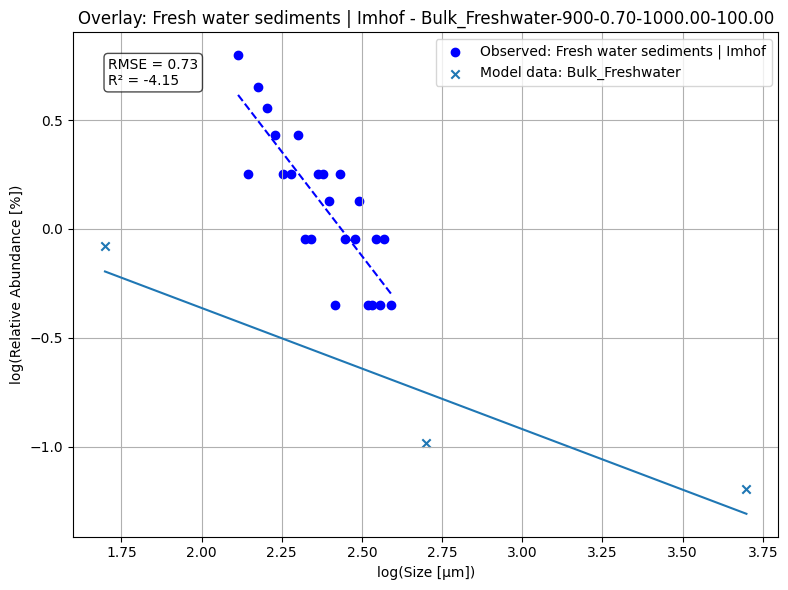

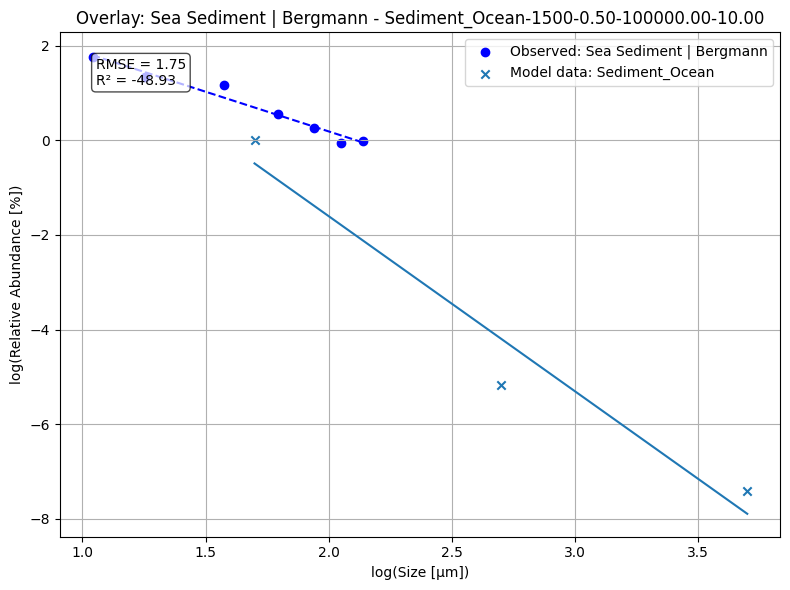

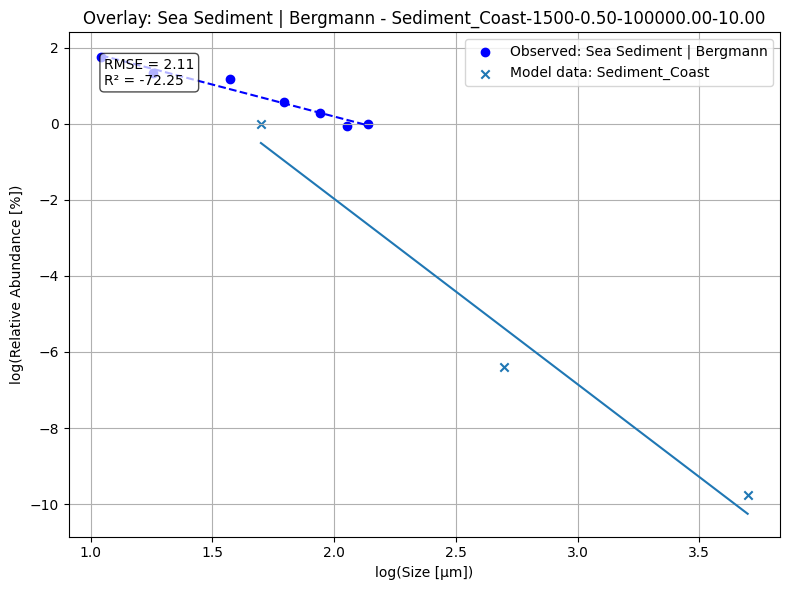

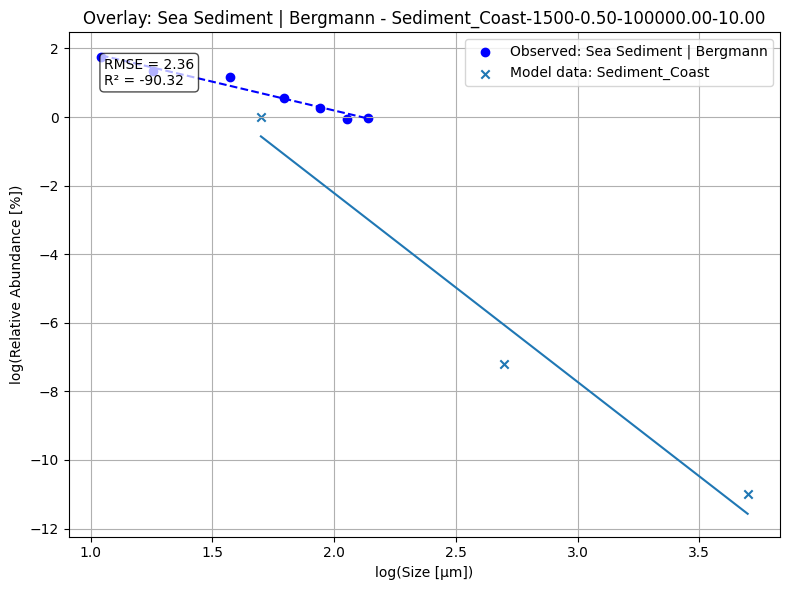

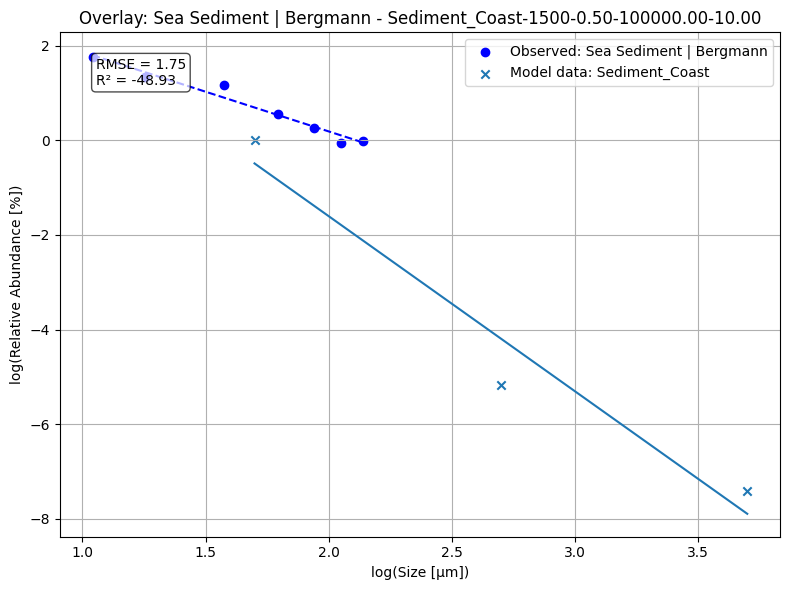

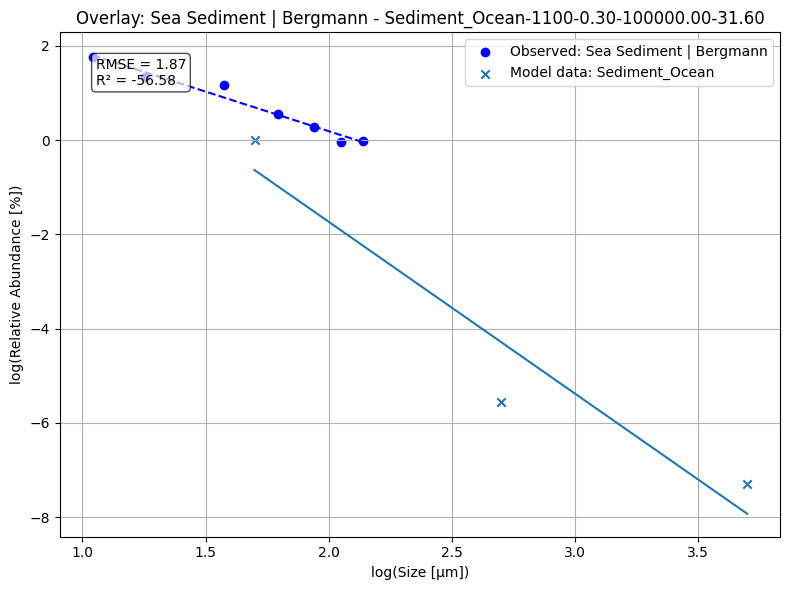

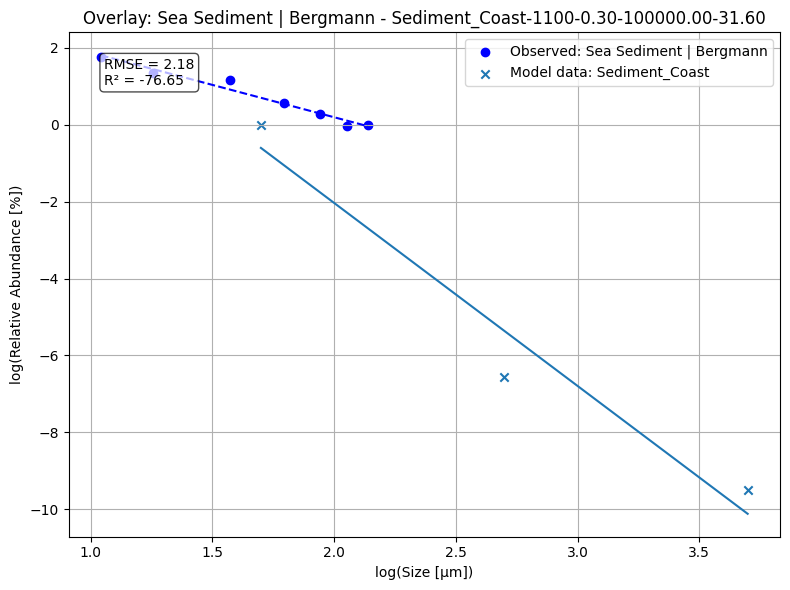

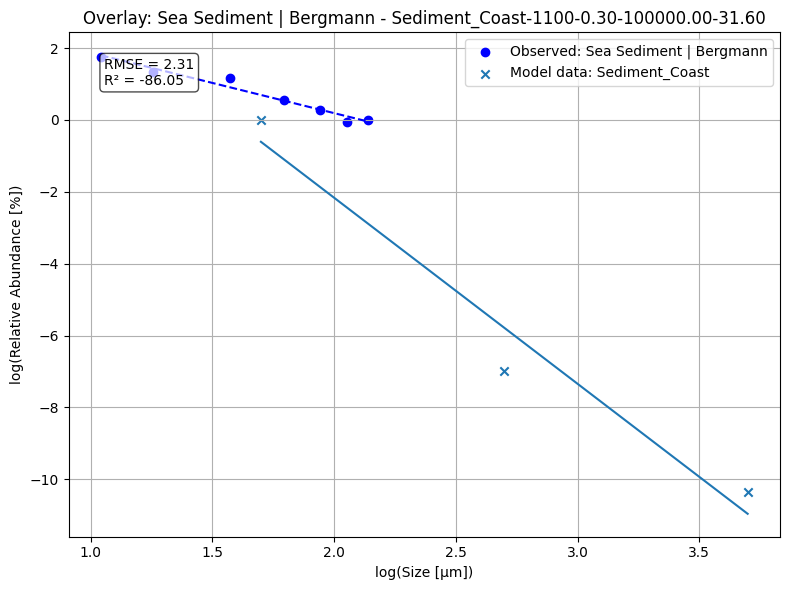

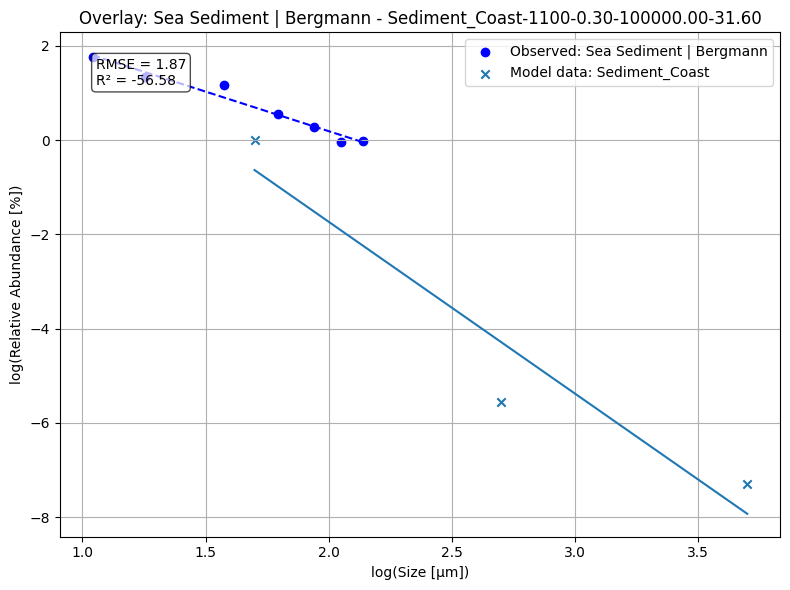

In [62]:

run_and_plot_top_results(top_results)

Correlation heat maps for top results

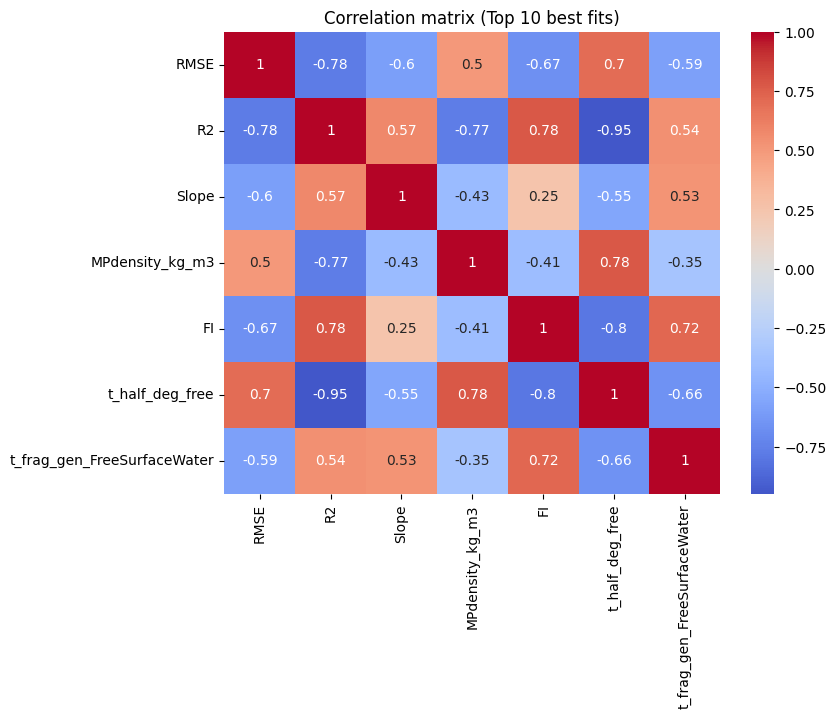

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = top_results[["RMSE", "R2", "Slope", "MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 10 best fits)")
plt.show()


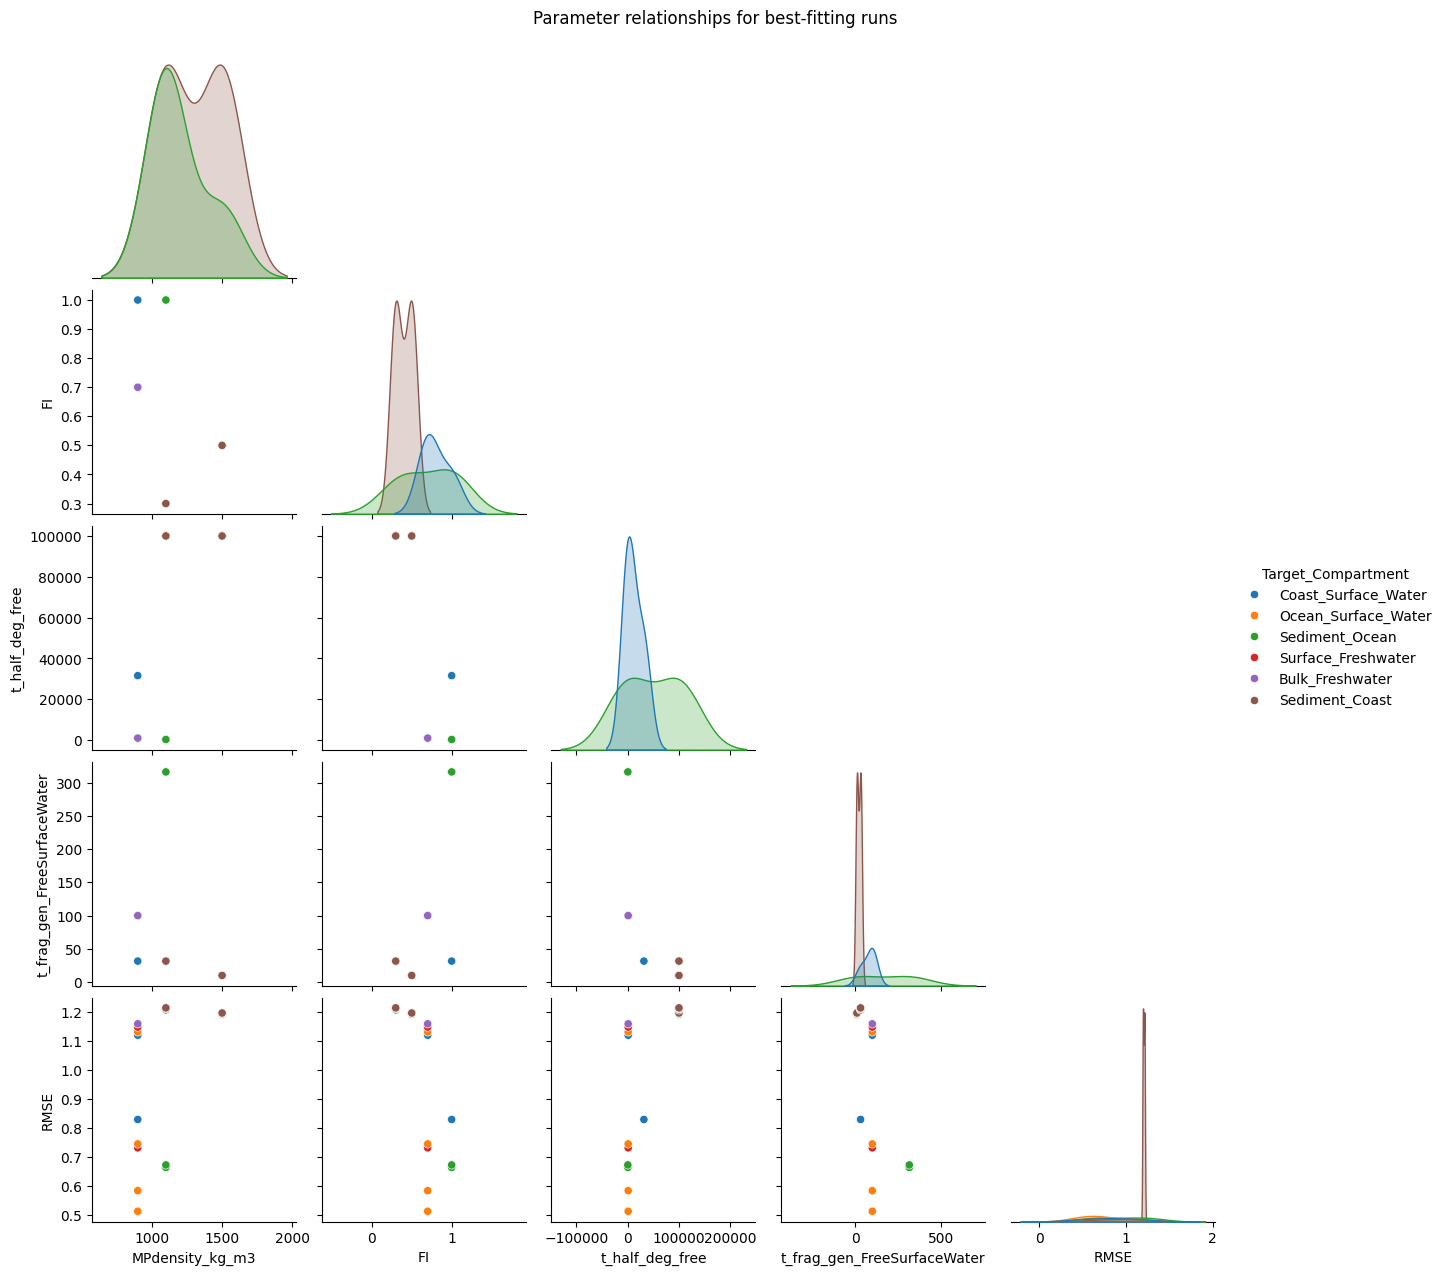

In [64]:
# Pair-wise relationships for the top results
sns.pairplot(
    top_results,
    vars=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","RMSE"],
    hue="Target_Compartment",
    corner=True
)
plt.suptitle("Parameter relationships for best-fitting runs", y=1.02)
plt.show()


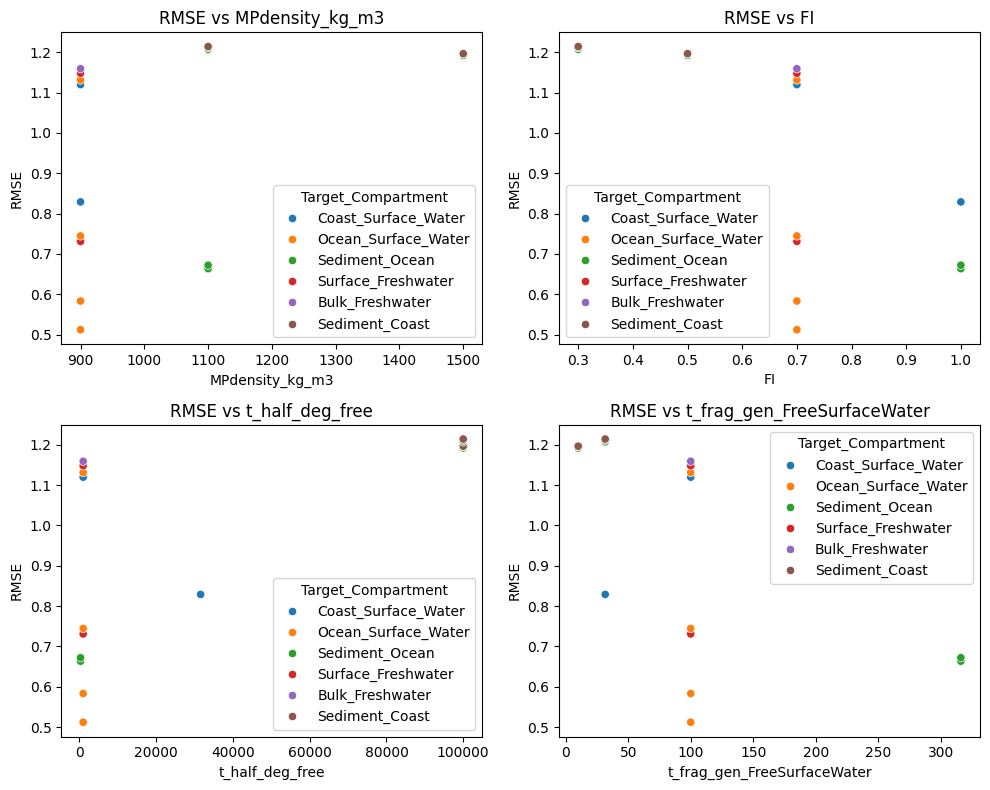

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

params = ["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]

for ax, param in zip(axes.ravel(), params):
    sns.scatterplot(data=top_results, x=param, y="RMSE", hue="Target_Compartment", ax=ax)
    ax.set_title(f"RMSE vs {param}")

plt.tight_layout()
plt.show()


Pearson r = -0.577, p = 1.685e-77
Spearman ρ = -0.547, p = 2.785e-68


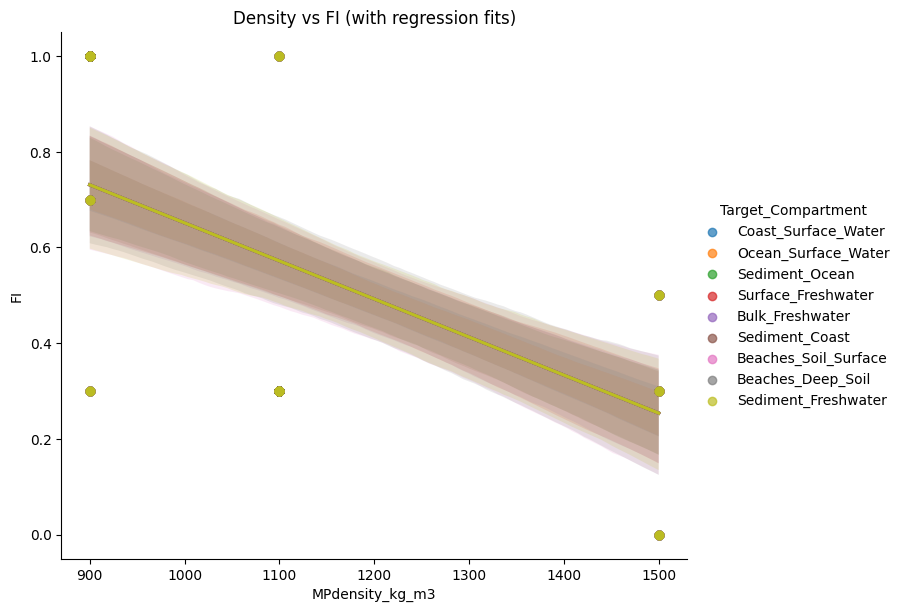

In [66]:
# Pearson & Spearman correlation between Density and FI for all results

# Pearson tests linear correlation.

# Spearman tests monotonic correlation (rank-based, robust to nonlinearities).

# If p < 0.05, the correlation is statistically significant.

from scipy.stats import pearsonr, spearmanr

x = results_sorted["MPdensity_kg_m3"]
y = results_sorted["FI"]

pearson_corr, pearson_p = pearsonr(x, y)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson r = {pearson_corr:.3f}, p = {pearson_p:.3e}")
print(f"Spearman ρ = {spearman_corr:.3f}, p = {spearman_p:.3e}")

import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=results_sorted, 
    x="MPdensity_kg_m3", 
    y="FI", 
    hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()



Best fits Pearson r = -0.438


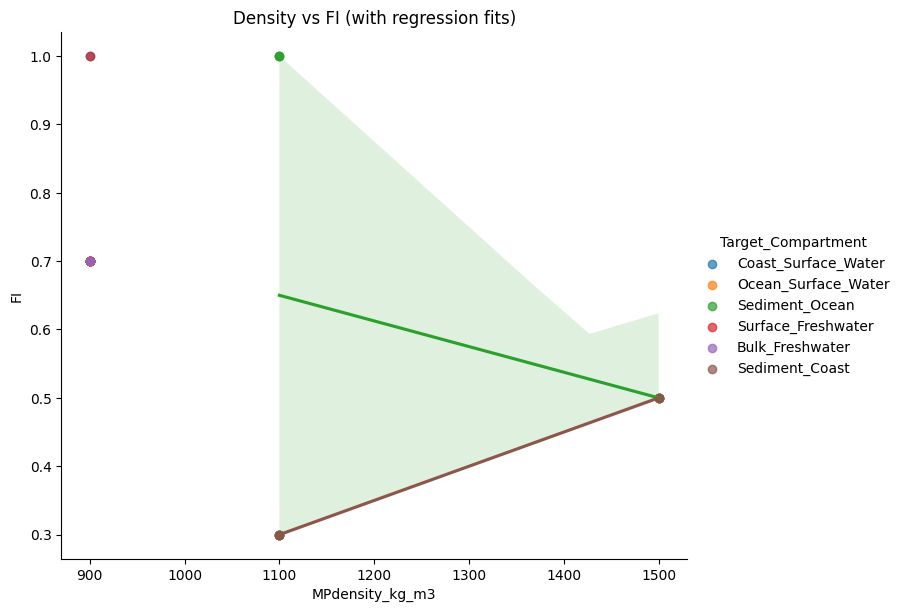

In [67]:

# Pearson & Spearman correlation between Density and FI for best fits (e.g. lowest 10% RMSE)

threshold = results_sorted["RMSE"].quantile(0.1)  # lowest 10% of RMSE
best_fits = results_sorted[results_sorted["RMSE"] <= threshold]

pearson_corr, _ = pearsonr(best_fits["MPdensity_kg_m3"], best_fits["FI"])
print(f"Best fits Pearson r = {pearson_corr:.3f}")


sns.lmplot(
    data=best_fits, 
    x="MPdensity_kg_m3", 
    y="FI", 
    hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()

In [68]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# Keep only best 10% RMSE across all compartments
threshold = results_sorted["RMSE"].quantile(0.1)
best_fits = results_sorted[results_sorted["RMSE"] <= threshold]

results = []

for comp in best_fits["Target_Compartment"].unique():
    subset = best_fits[best_fits["Target_Compartment"] == comp]
    
    if len(subset) > 2:  # need at least 3 points
        pearson_corr, pearson_p = pearsonr(subset["MPdensity_kg_m3"], subset["FI"])
        spearman_corr, spearman_p = spearmanr(subset["MPdensity_kg_m3"], subset["FI"])
    else:
        pearson_corr, pearson_p, spearman_corr, spearman_p = [None]*4
    
    results.append({
        "Target_Compartment": comp,
        "Pearson_r": pearson_corr,
        "Pearson_p": pearson_p,
        "Spearman_rho": spearman_corr,
        "Spearman_p": spearman_p,
        "n_points": len(subset)
    })

correlation_best = pd.DataFrame(results)
print(correlation_best)


    Target_Compartment  Pearson_r  Pearson_p  Spearman_rho  Spearman_p  \
0  Coast_Surface_Water        NaN        NaN           NaN         NaN   
1  Ocean_Surface_Water        NaN        NaN           NaN         NaN   
2       Sediment_Ocean  -0.240192   0.533603           0.0         1.0   
3   Surface_Freshwater        NaN        NaN           NaN         NaN   
4      Bulk_Freshwater        NaN        NaN           NaN         NaN   
5       Sediment_Coast   1.000000   0.000000           1.0         0.0   

   n_points  
0         7  
1         9  
2         9  
3         4  
4         2  
5         6  


C:\Users\PradoDomercq\AppData\Local\Temp\ipykernel_30064\2572835342.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(subset["MPdensity_kg_m3"], subset["FI"])
C:\Users\PradoDomercq\AppData\Local\Temp\ipykernel_30064\2572835342.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(subset["MPdensity_kg_m3"], subset["FI"])


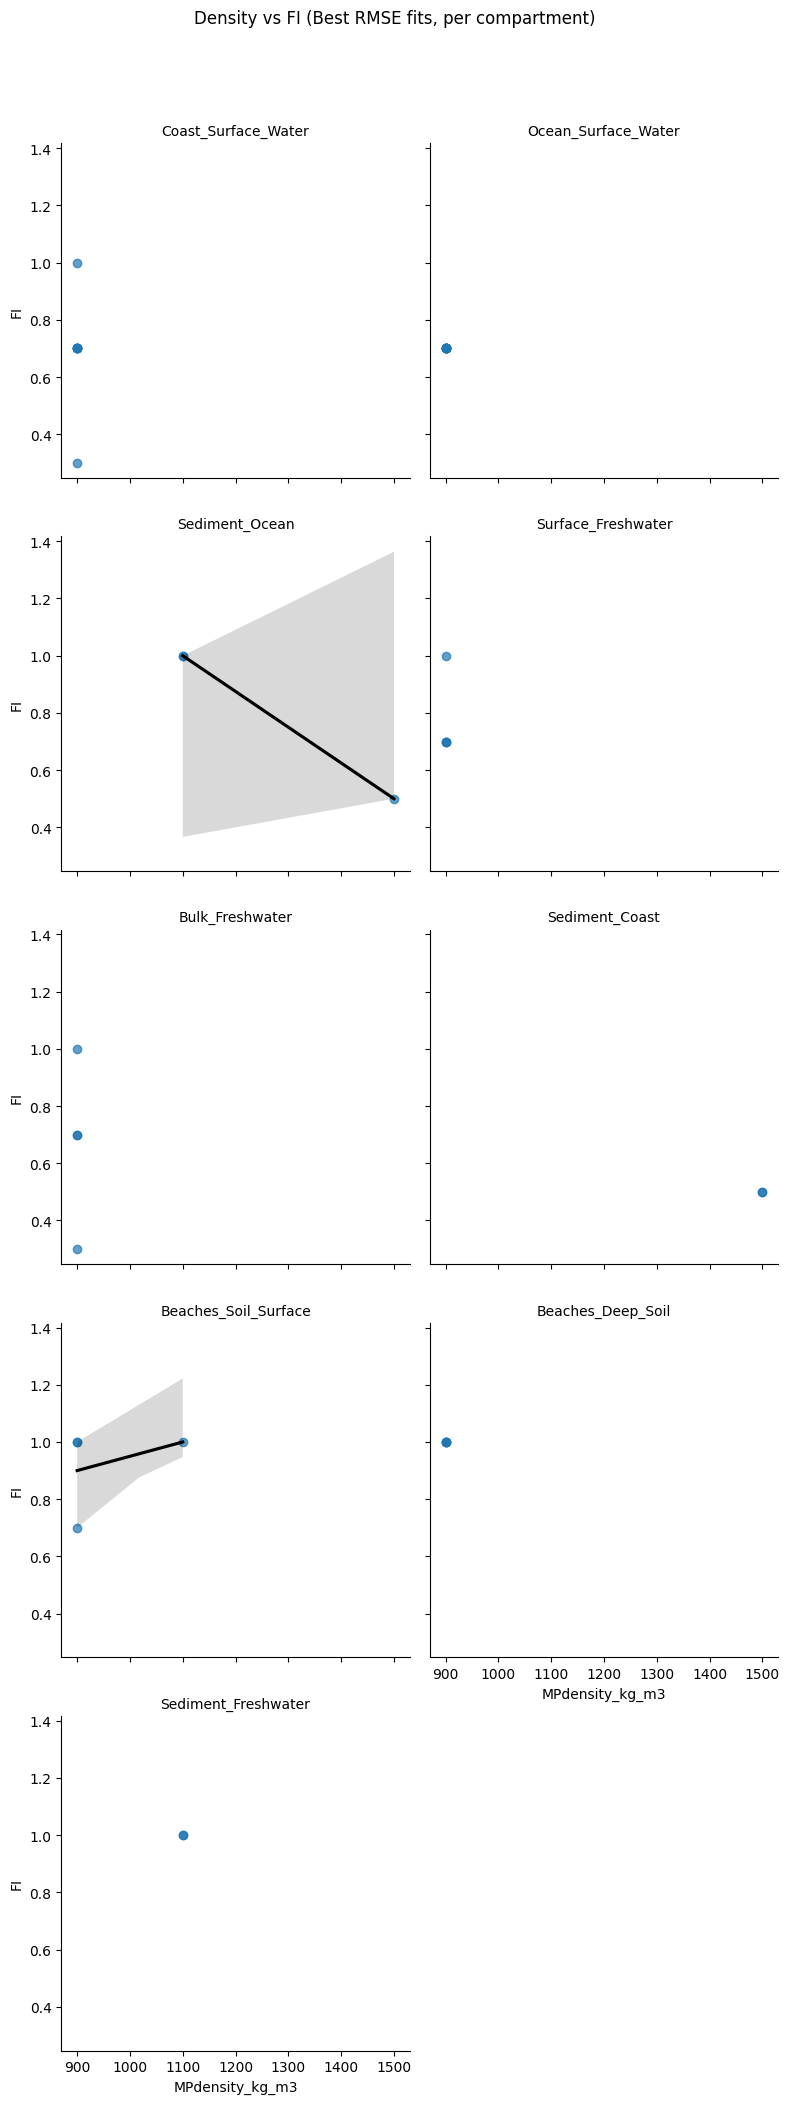

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- pick best fits per compartment (lowest 10% RMSE) ---
best_fits_list = []

for comp in results_sorted["Target_Compartment"].unique():
    subset = results_sorted[results_sorted["Target_Compartment"] == comp]
    if len(subset) > 2:
        threshold = subset["RMSE"].quantile(0.1)   # lowest 10%
        best_subset = subset[subset["RMSE"] <= threshold]
        best_fits_list.append(best_subset)

best_fits = pd.concat(best_fits_list, ignore_index=True)

# --- plot each compartment separately ---
g = sns.lmplot(
    data=best_fits,
    x="MPdensity_kg_m3",
    y="FI",
    col="Target_Compartment",   # separate plot per compartment
    col_wrap=2,                 # wrap panels (2 per row)
    height=4,
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "black"}
)

g.set_titles("{col_name}")
plt.suptitle("Density vs FI (Best RMSE fits, per compartment)", y=1.05)
plt.show()



### Plot sensitivity indices for each output variable.  Monaco uses the D-VARS approach to calculating global sensitivity indices.

In [120]:
sim.outvars

{'Observed_dataset': <monaco.mc_var.OutVar at 0x2755791a7d0>,
 'Coast_Surface_Water_Spearman_r': <monaco.mc_var.OutVar at 0x27555ebad90>,
 'Coast_Surface_Water_Spearman_p': <monaco.mc_var.OutVar at 0x2755791b0d0>,
 'Coast_Surface_Water_Pass_Spearman': <monaco.mc_var.OutVar at 0x27555fb1fd0>,
 'Coast_Surface_Water_RMSE': <monaco.mc_var.OutVar at 0x27555fb2cd0>,
 'Coast_Surface_Water_R_squared': <monaco.mc_var.OutVar at 0x27555fb2b90>,
 'Coast_Surface_Water_Model_slope': <monaco.mc_var.OutVar at 0x27555fb1dd0>,
 'Coast_Surface_Water_Model_intercept': <monaco.mc_var.OutVar at 0x27555fb1f10>,
 'Ocean_Surface_Water_Spearman_r': <monaco.mc_var.OutVar at 0x27555fb0f10>,
 'Ocean_Surface_Water_Spearman_p': <monaco.mc_var.OutVar at 0x27555fb0150>,
 'Ocean_Surface_Water_Pass_Spearman': <monaco.mc_var.OutVar at 0x27555fb1e90>,
 'Ocean_Surface_Water_RMSE': <monaco.mc_var.OutVar at 0x27555fb0dd0>,
 'Ocean_Surface_Water_R_squared': <monaco.mc_var.OutVar at 0x27555fb3150>,
 'Ocean_Surface_Water_Model_

In [70]:
sim.calcSensitivities("C_g_m3_Ocean_Surface_Water")
fig, ax = sim.outvars["C_g_m3_Ocean_Surface_Water"].plotSensitivities()

KeyError: 'C_g_m3_Ocean_Surface_Water'

Calculating sensitivity indices for 'persistence_number'...
Calculating optimal hyperparameters Φ for 'persistence_number' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


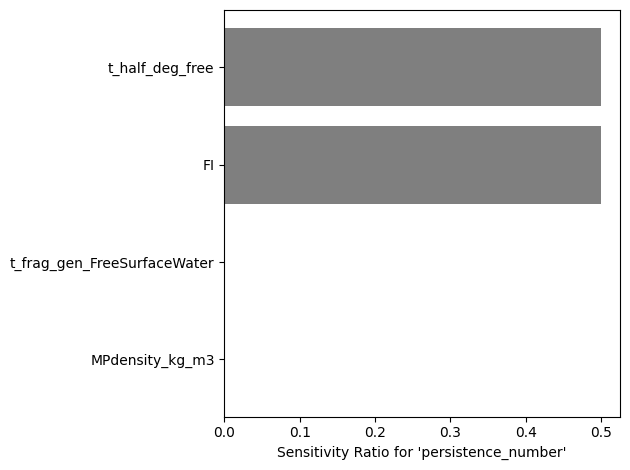

In [71]:
sim.calcSensitivities("persistence_number")
fig, ax = sim.outvars["persistence_number"].plotSensitivities()

Variable: Coast_Surface_Water_Spearman_r
Calculating sensitivity indices for 'Coast_Surface_Water_Spearman_r'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Spearman_r' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


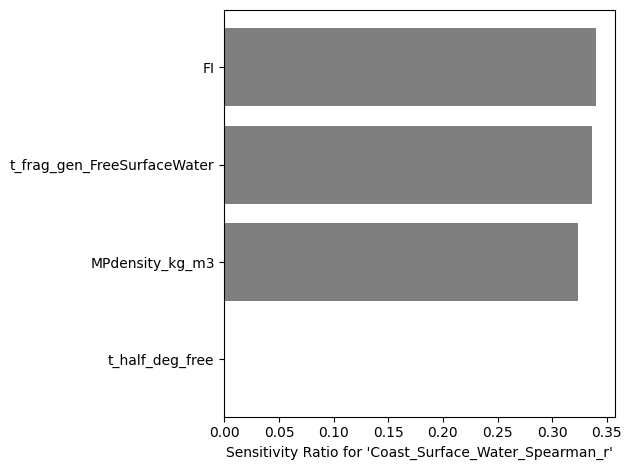

Variable: Coast_Surface_Water_Spearman_p
Calculating sensitivity indices for 'Coast_Surface_Water_Spearman_p'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Spearman_p' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


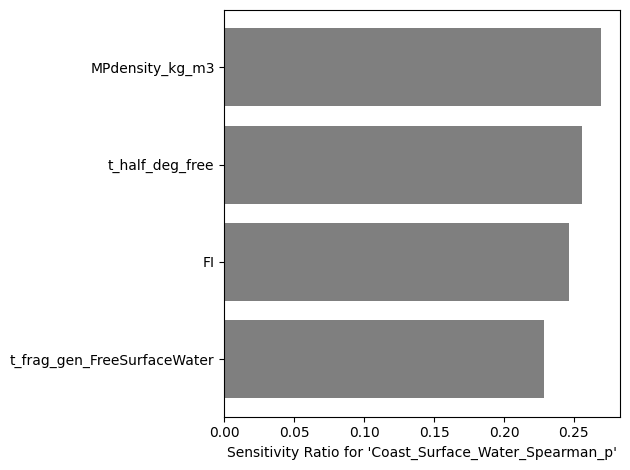

Variable: Coast_Surface_Water_Pass_Spearman
Calculating sensitivity indices for 'Coast_Surface_Water_Pass_Spearman'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Pass_Spearman' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


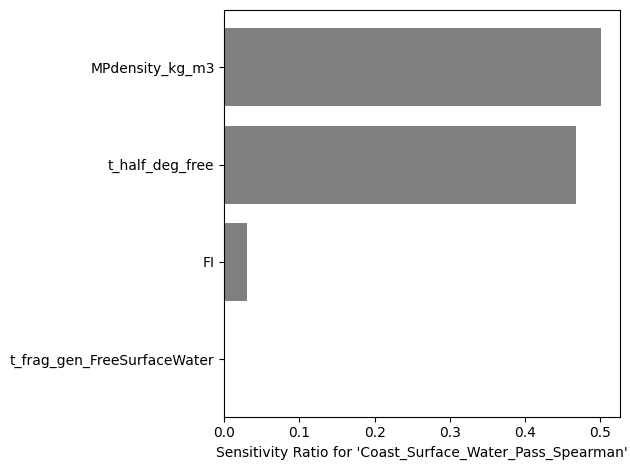

Variable: Coast_Surface_Water_RMSE
Calculating sensitivity indices for 'Coast_Surface_Water_RMSE'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_RMSE' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


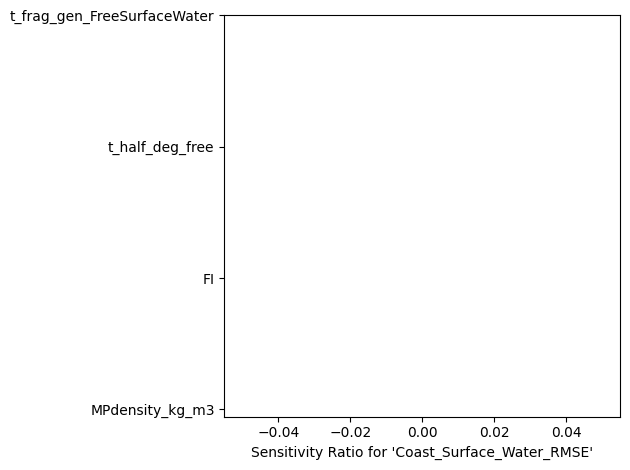

Variable: Coast_Surface_Water_R_squared
Calculating sensitivity indices for 'Coast_Surface_Water_R_squared'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_R_squared' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


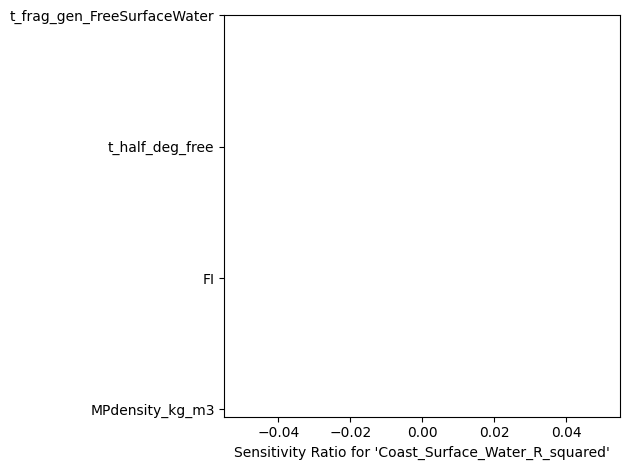

Variable: Coast_Surface_Water_Model_slope
Calculating sensitivity indices for 'Coast_Surface_Water_Model_slope'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Model_slope' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


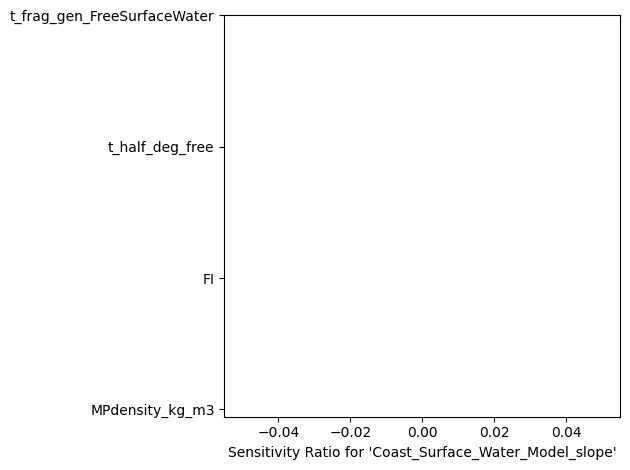

Variable: Coast_Surface_Water_Model_intercept
Calculating sensitivity indices for 'Coast_Surface_Water_Model_intercept'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Model_intercept' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


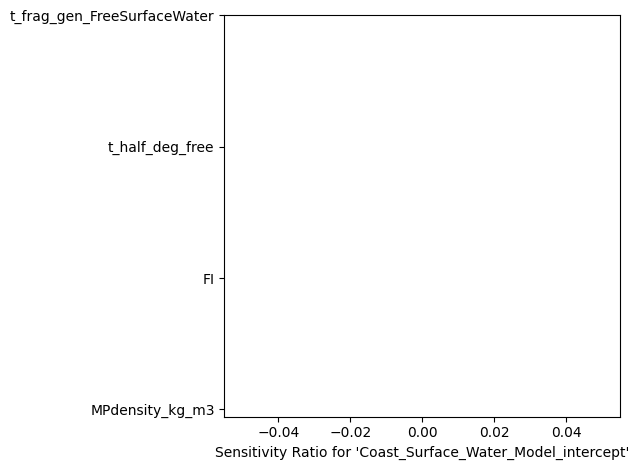

c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:277: RuntimeWarning: invalid value encountered in log
  L = np.log(Rdet)/m + m*np.log(L_inner.T @ Rinv @ L_inner)
Running cases:  45%|████▌     | 9/20 [1:10:03<1:25:37, 467.04s/ cases]

Variable: Ocean_Surface_Water_Spearman_r
Calculating sensitivity indices for 'Ocean_Surface_Water_Spearman_r'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Spearman_r' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


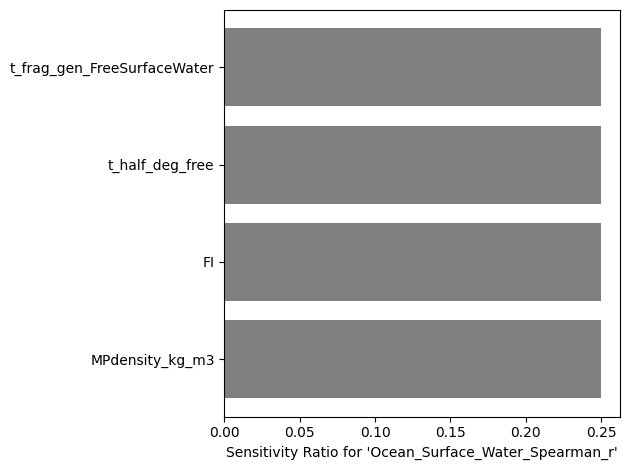

Variable: Ocean_Surface_Water_Spearman_p
Calculating sensitivity indices for 'Ocean_Surface_Water_Spearman_p'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Spearman_p' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


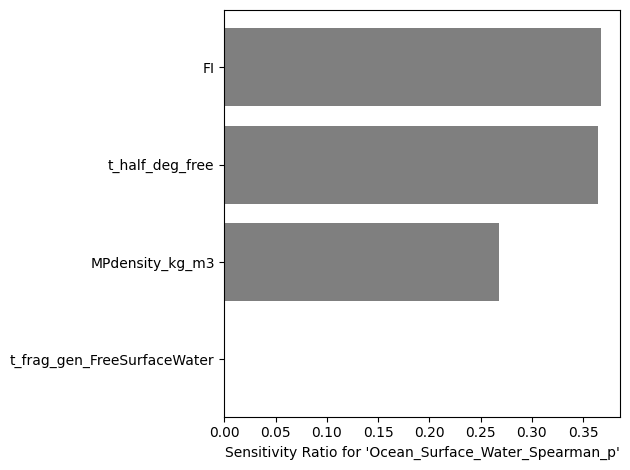

Variable: Ocean_Surface_Water_Pass_Spearman
Calculating sensitivity indices for 'Ocean_Surface_Water_Pass_Spearman'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Pass_Spearman' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


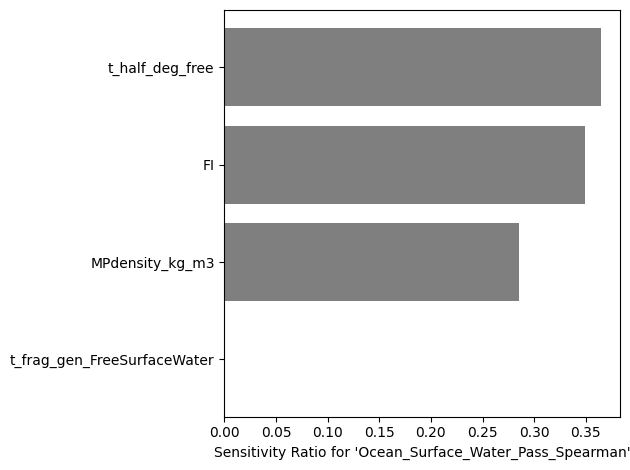

Variable: Ocean_Surface_Water_RMSE
Calculating sensitivity indices for 'Ocean_Surface_Water_RMSE'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_RMSE' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


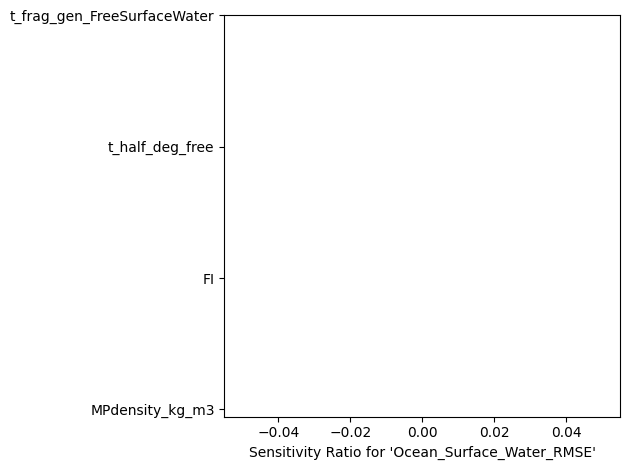

Variable: Ocean_Surface_Water_R_squared
Calculating sensitivity indices for 'Ocean_Surface_Water_R_squared'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_R_squared' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


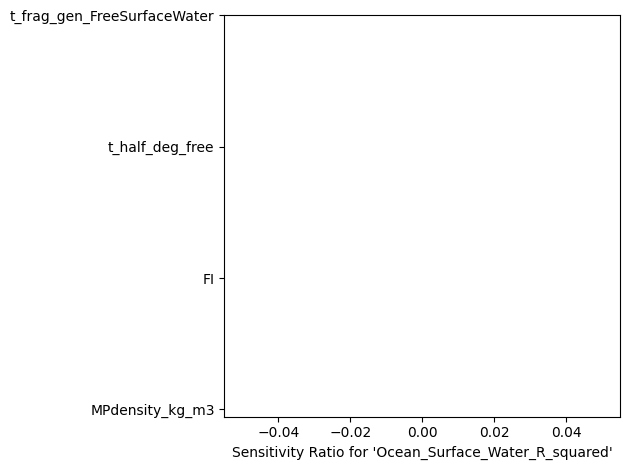

Variable: Ocean_Surface_Water_Model_slope
Calculating sensitivity indices for 'Ocean_Surface_Water_Model_slope'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Model_slope' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


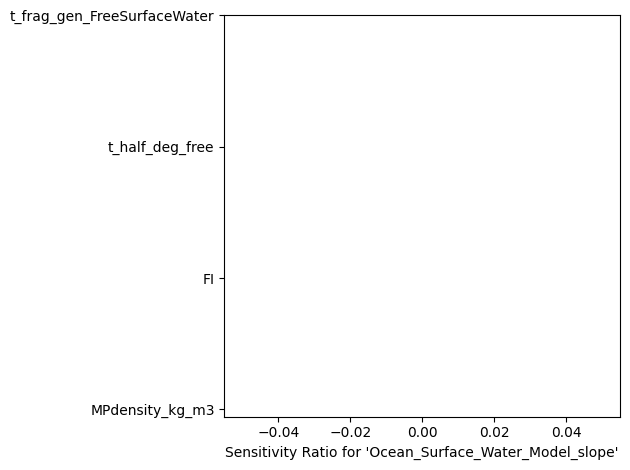

Variable: Ocean_Surface_Water_Model_intercept
Calculating sensitivity indices for 'Ocean_Surface_Water_Model_intercept'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Model_intercept' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


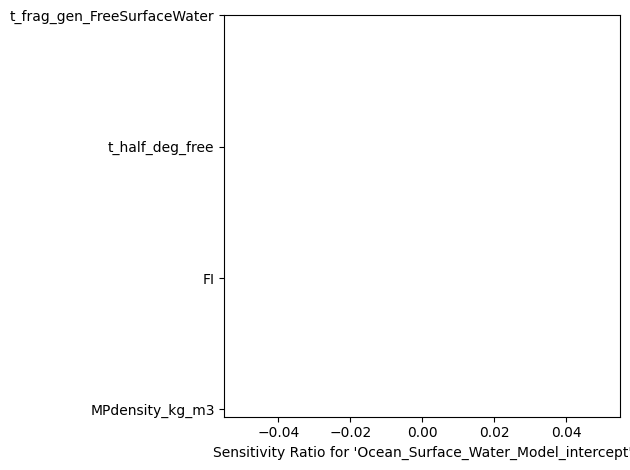

Variable: residence_time_mass
Calculating sensitivity indices for 'residence_time_mass'...
Calculating optimal hyperparameters Φ for 'residence_time_mass' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


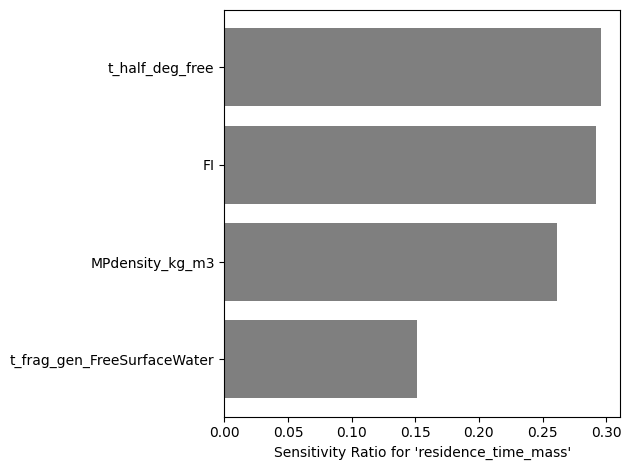

Variable: residence_time_number
Calculating sensitivity indices for 'residence_time_number'...
Calculating optimal hyperparameters Φ for 'residence_time_number' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


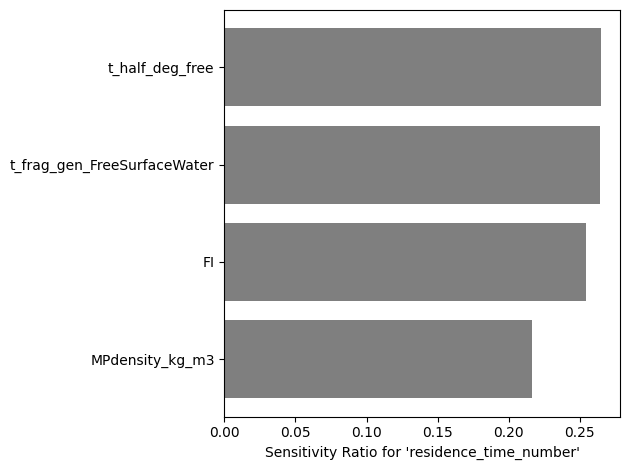

Variable: persistence_mass
Calculating sensitivity indices for 'persistence_mass'...
Calculating optimal hyperparameters Φ for 'persistence_mass' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


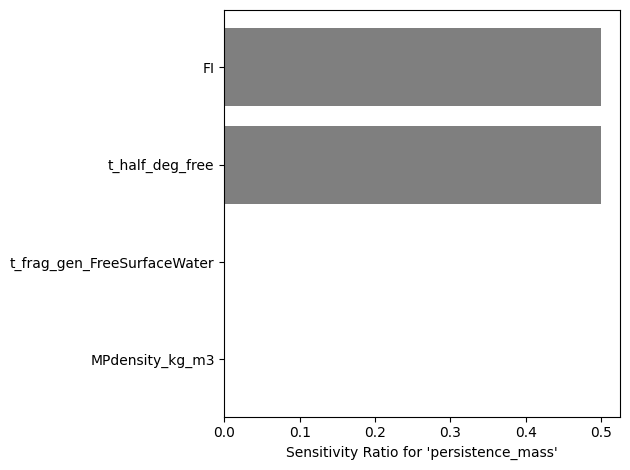

Variable: persistence_number
Calculating sensitivity indices for 'persistence_number'...
Calculating optimal hyperparameters Φ for 'persistence_number' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


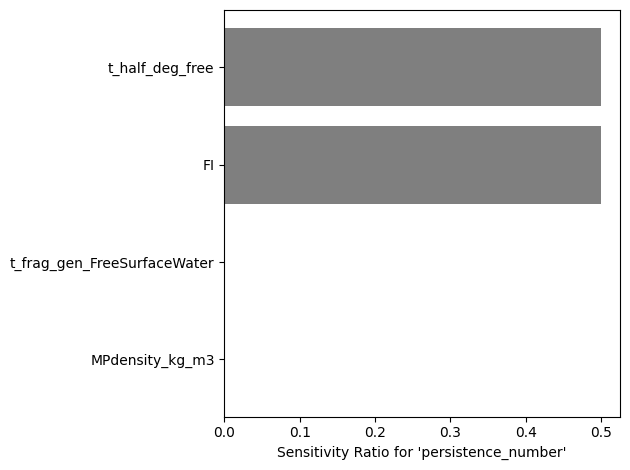

In [72]:
import matplotlib.pyplot as plt

for var in sim.outvars:
    print(f"Variable: {var}")
    sim.calcSensitivities(var)
    fig, ax = sim.outvars[var].plotSensitivities()

    plt.show()

### Plot 

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='MPdensity_kg_m3'>,
  <Axes: ylabel='residence_time_number'>,
  <Axes: >))

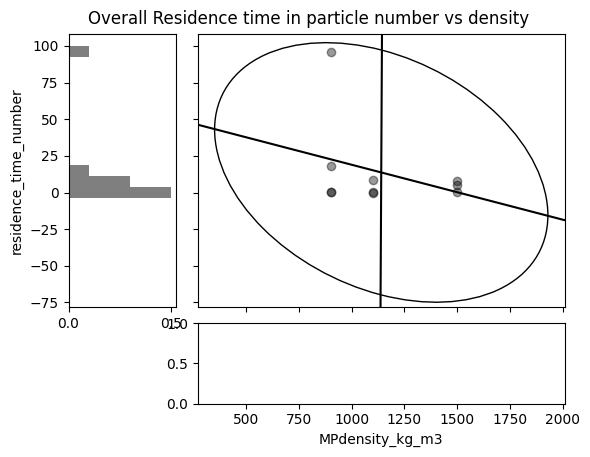

In [73]:
import monaco as mc

mc.multi_plot([sim.invars["MPdensity_kg_m3"],sim.outvars["residence_time_number"]],title="Overall Residence time in particle number vs density",cov_plot=True)

In [80]:
sim.outvars.keys()

dict_keys(['Coast_Surface_Water_Spearman_r', 'Coast_Surface_Water_Spearman_p', 'Coast_Surface_Water_Pass_Spearman', 'Coast_Surface_Water_RMSE', 'Coast_Surface_Water_R_squared', 'Coast_Surface_Water_Model_slope', 'Coast_Surface_Water_Model_intercept', 'Ocean_Surface_Water_Spearman_r', 'Ocean_Surface_Water_Spearman_p', 'Ocean_Surface_Water_Pass_Spearman', 'Ocean_Surface_Water_RMSE', 'Ocean_Surface_Water_R_squared', 'Ocean_Surface_Water_Model_slope', 'Ocean_Surface_Water_Model_intercept', 'residence_time_mass', 'residence_time_number', 'persistence_mass', 'persistence_number'])

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='MPdensity_kg_m3'>,
  <Axes: ylabel='persistence_mass'>,
  <Axes: >))

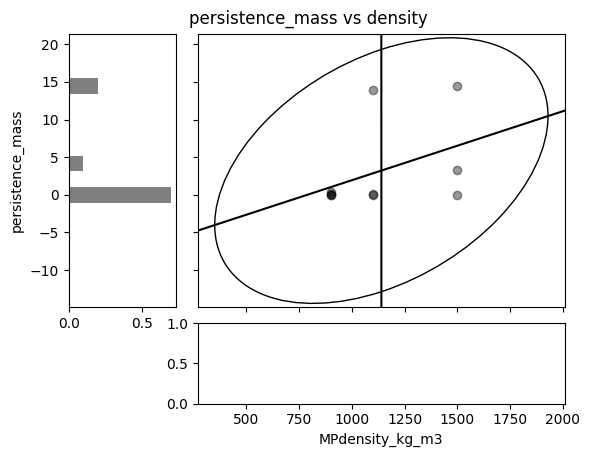

In [81]:

mc.multi_plot([sim.invars["MPdensity_kg_m3"],sim.outvars["persistence_mass"]],title="persistence_mass vs density",cov_plot=True)

In [13]:
# Reproduce best performing parameters sets from Rakesh
art= "Sea Sediment | Bergmann"
comp= "Coast_Column_Water"
data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 25000)

In [14]:
data_data["MPdensity_kg_m3"]= 1100
data_data["FI"]= 1
data_data["t_half_deg_free"]= 316
data_data["t_frag_gen_FreeSurfaceWater"]= 316


In [15]:
from utopia.utopia import utopiaModel
from utopia.results_processing.process_results import *
from scipy.stats import spearmanr
model = utopiaModel(config=config_data, data=data_data)
model.run()
processor = ResultsProcessor(model)
processor.estimate_flows()
processor.generate_flows_dict()
processor.process_results() 
processor.extract_results_by_compartment()
df = processor.results_by_comp
df2 = processor.Results_extended
processor.estimate_exposure_indicators()

In [16]:
observed_file = "../src/utopia/data/observed_data_long.xlsx"

observed_df = pd.read_excel(observed_file)

observed_df = observed_df.rename(
    columns={
        "dataset identifier": "Dataset",
        "Article name": "Article",
        "log‑transformed size": "log_Size",
        "log‑transformed abundance": "log_Abundance",
        }
    )

obs_subset = observed_df[observed_df["Article"] == art]
x_obs_all = obs_subset["log_Size"].astype(float).values
y_obs_all = obs_subset["log_Abundance"].astype(float).values

In [17]:
if len(x_obs_all) >= 2:
    slope_obs, intercept_obs = np.polyfit(x_obs_all, y_obs_all, 1)
else:
    slope_obs, intercept_obs = np.nan, np.nan

In [13]:
def extract_log_rel_abundance(model_df, compartment, value_col="fraction"):
    """
    Process model outputs into log-relative abundances per size fraction.

    Parameters
    ----------
    model_df : pd.DataFrame
        Must contain columns: 'compartment', 'aggregation_state', 'size_fraction', and a value column (e.g. 'fraction').
    compartment : str
        The compartment to filter on (e.g., 'water').
    value_col : str
        The column with the fraction values (e.g., 'fraction_mass' or 'fraction_number').

    Returns
    -------
    pd.DataFrame
        Columns: ['size_fraction', 'relative_abundance', 'log_size', 'log_rel_abundance']
    """

    # 1. Filter for compartment of interest
    df = model_df[model_df["Compartment"] == compartment].copy()

    # 2. Aggregate over aggregation states (sum fractions within size fractions)
    df_grouped = df.groupby("Size_Fraction_um")[value_col].sum().reset_index()

    # 3. Normalize to relative abundance across all size fractions
    df_grouped["relative_abundance"] = (
        df_grouped[value_col] / df_grouped[value_col].sum()
    )

    # 4. Convert to log10 scale
    df_grouped["log_size"] = np.log10(df_grouped["Size_Fraction_um"])
    df_grouped["log_rel_abundance"] = np.log10(df_grouped["relative_abundance"])

    return df_grouped[
        ["Size_Fraction_um", "relative_abundance", "log_size", "log_rel_abundance"]
    ]

In [18]:
overlay_compartments_mapping[art]

['Sediment_Coast', 'Sediment_Ocean']

In [27]:
model_df=processor.Results_extended
compartment="Sediment_Ocean"
value_col="number_of_particles"

In [28]:
df=model_df[model_df["Compartment"] == compartment]

In [17]:
df

,Compartment,MP_Form,Size_Fraction_um,mass_g,number_of_particles,concentration_g_m3,concentration_num_m3,mass_fraction,number_fraction,inflows_g_s,inflows_num_s,outflows_g_s,outflows_num_s,Total_inflows_g_s,Total_outflows_g_s,Total_inflows_num_s,Total_outflows_num_s
species,,,,,,,,,,,,,,,,,
aA8_Utopia,Sediment_Ocean,freeMP,0.5,1.371981e-10,1.905666e+03,1.401411e-23,1.946544e-10,1.399393e-21,5.774951e-10,"{'k_settling': 7.52084078495283e-23, 'k_fragme...","{'k_settling': 1.0446362069518896e-09, 'k_frag...","{'k_discorporation': 3.483154845388248e-24, 'k...","{'k_discorporation': 4.8380623522736823e-11, '...",6.997452e-20,6.997452e-20,2.015530e-09,9.719381e-07
bA8_Utopia,Sediment_Ocean,freeMP,5.0,1.908419e-07,2.650772e+03,1.949355e-20,2.707633e-10,1.946549e-18,8.032928e-10,"{'k_settling': 8.494905082766526e-17, 'k_fragm...","{'k_settling': 1.1799326269254622e-06, 'k_frag...","{'k_discorporation': 4.845051213697657e-19, 'k...","{'k_discorporation': 6.729720874414857e-09, 'k...",9.788377e-17,9.788377e-17,1.180112e-06,1.359594e-06
cA8_Utopia,Sediment_Ocean,freeMP,50.0,3.531490e-06,4.905199e+01,3.607242e-19,5.010418e-12,3.602048e-17,1.486477e-11,"{'k_settling': 1.8110225551147622e-15, 'k_frag...","{'k_settling': 2.5154896729957426e-08, 'k_frag...","{'k_discorporation': 8.965667189539691e-16, 'k...","{'k_discorporation': 1.245320946617073e-08, 'k...",2.710561e-15,2.710561e-15,2.516739e-08,3.764939e-08
dA8_Utopia,Sediment_Ocean,freeMP,500.0,2.455957e-05,3.411296e-01,2.508638e-18,3.484470e-14,2.505026e-16,1.033763e-13,"{'k_settling': 3.215794139651081e-14, 'k_fragm...","{'k_settling': 4.4667013814523775e-10, 'k_frag...","{'k_discorporation': 6.235127651741097e-13, 'k...","{'k_discorporation': 8.660521192001956e-09, 'k...",6.369377e-13,6.369377e-13,4.550705e-10,8.846992e-09
eA8_Utopia,Sediment_Ocean,freeMP,5000.0,1.651194e-03,2.293489e-02,1.686613e-16,2.342686e-15,1.684184e-14,6.950215e-15,"{'k_settling': 4.193460618464524e-09, 'k_fragm...","{'k_settling': 5.824668969511203e-08, 'k_fragm...","{'k_discorporation': 4.192013729862837e-09, 'k...","{'k_discorporation': 5.822659257746301e-08, 'k...",4.193461e-09,4.193461e-09,5.824669e-08,5.824669e-08
aB8_Utopia,Sediment_Ocean,heterMP,0.5,2.445179e-07,3.396325e+06,2.497629e-20,3.469178e-07,2.494033e-18,1.029226e-06,"{'k_settling': 6.186203484304605e-18, 'k_fragm...","{'k_settling': 2.227881673142928e-08, 'k_fragm...","{'k_discorporation': 1.3075075103394794e-19, '...","{'k_discorporation': 1.8161130187663038e-06, '...",1.248349e-16,1.248349e-16,3.616679e-07,1.733942e-03
bB8_Utopia,Sediment_Ocean,heterMP,5.0,2.031292e-02,2.821441e+08,2.074864e-15,2.881963e-05,2.071877e-13,8.550126e-05,"{'k_settling': 6.612993115226345e-13, 'k_fragm...","{'k_settling': 0.0018916163846340833, 'k_fragm...","{'k_discorporation': 1.311534024235109e-14, 'k...","{'k_discorporation': 0.0001821705800641948, 'k...",1.037282e-11,1.037282e-11,2.025990e-03,1.440773e-01
cB8_Utopia,Sediment_Ocean,heterMP,50.0,2.648784e+02,3.679131e+09,2.705601e-11,3.758050e-04,2.701706e-09,1.114928e-03,"{'k_settling': 1.3072337144093125e-07, 'k_frag...","{'k_settling': 1.8087584500195535, 'k_fragment...","{'k_discorporation': 6.738365170079272e-09, 'k...","{'k_discorporation': 0.09359512365175647, 'k_f...",1.418361e-07,1.418361e-07,1.808913e+00,1.970087e+00
dB8_Utopia,Sediment_Ocean,heterMP,500.0,3.034026e+04,4.214227e+08,3.099107e-09,4.304624e-05,3.094645e-07,1.277084e-04,"{'k_settling': 3.213524807839965e-05, 'k_fragm...","{'k_settling': 0.4463532094818762, 'k_fragment...","{'k_discorporation': 7.702731486693613e-05, 'k...","{'k_discorporation': 1.0699006179638157, 'k_fr...",9.251196e-05,9.251196e-05,4.471918e-01,1.284981e+00


In [29]:
excluded_sizes = [0.5, 5]
filtered_Results = df[
    ~df["Size_Fraction_um"].isin(excluded_sizes)
]
filtered_Results

,Compartment,MP_Form,Size_Fraction_um,mass_g,number_of_particles,concentration_g_m3,concentration_num_m3,mass_fraction,number_fraction,inflows_g_s,inflows_num_s,outflows_g_s,outflows_num_s,Total_inflows_g_s,Total_outflows_g_s,Total_inflows_num_s,Total_outflows_num_s
species,,,,,,,,,,,,,,,,,
cA8_Utopia,Sediment_Ocean,freeMP,50.0,3.531490e-06,4.905199e+01,3.607242e-19,5.010418e-12,3.602048e-17,1.486477e-11,"{'k_settling': 1.8110225551147622e-15, 'k_frag...","{'k_settling': 2.5154896729957426e-08, 'k_frag...","{'k_discorporation': 8.965667189539691e-16, 'k...","{'k_discorporation': 1.245320946617073e-08, 'k...",2.710561e-15,2.710561e-15,2.516739e-08,3.764939e-08
dA8_Utopia,Sediment_Ocean,freeMP,500.0,2.455957e-05,3.411296e-01,2.508638e-18,3.484470e-14,2.505026e-16,1.033763e-13,"{'k_settling': 3.215794139651081e-14, 'k_fragm...","{'k_settling': 4.4667013814523775e-10, 'k_frag...","{'k_discorporation': 6.235127651741097e-13, 'k...","{'k_discorporation': 8.660521192001956e-09, 'k...",6.369377e-13,6.369377e-13,4.550705e-10,8.846992e-09
eA8_Utopia,Sediment_Ocean,freeMP,5000.0,1.651194e-03,2.293489e-02,1.686613e-16,2.342686e-15,1.684184e-14,6.950215e-15,"{'k_settling': 4.193460618464524e-09, 'k_fragm...","{'k_settling': 5.824668969511203e-08, 'k_fragm...","{'k_discorporation': 4.192013729862837e-09, 'k...","{'k_discorporation': 5.822659257746301e-08, 'k...",4.193461e-09,4.193461e-09,5.824669e-08,5.824669e-08
cB8_Utopia,Sediment_Ocean,heterMP,50.0,2.648784e+02,3.679131e+09,2.705601e-11,3.758050e-04,2.701706e-09,1.114928e-03,"{'k_settling': 1.3072337144093125e-07, 'k_frag...","{'k_settling': 1.8087584500195535, 'k_fragment...","{'k_discorporation': 6.738365170079272e-09, 'k...","{'k_discorporation': 0.09359512365175647, 'k_f...",1.418361e-07,1.418361e-07,1.808913e+00,1.970087e+00
dB8_Utopia,Sediment_Ocean,heterMP,500.0,3.034026e+04,4.214227e+08,3.099107e-09,4.304624e-05,3.094645e-07,1.277084e-04,"{'k_settling': 3.213524807839965e-05, 'k_fragm...","{'k_settling': 0.4463532094818762, 'k_fragment...","{'k_discorporation': 7.702731486693613e-05, 'k...","{'k_discorporation': 1.0699006179638157, 'k_fr...",9.251196e-05,9.251196e-05,4.471918e-01,1.284981e+00
eB8_Utopia,Sediment_Ocean,heterMP,5000.0,1.648429e+07,2.289649e+08,1.683789e-06,2.338763e-05,1.681364e-04,6.938577e-05,"{'k_settling': 4.19346199542075, 'k_fragmentat...","{'k_settling': 58.24670859628743, 'k_fragmenta...","{'k_discorporation': 4.184994630384546, 'k_fra...","{'k_discorporation': 58.12909808629004, 'k_fra...",4.193462e+00,4.193462e+00,5.824671e+01,5.824671e+01
cC8_Utopia,Sediment_Ocean,biofMP,50.0,2.679796e-07,1.520297e+00,2.737278e-20,1.552909e-13,2.733337e-18,4.607125e-13,"{'k_settling': 3.634101949539167e-16, 'k_fragm...","{'k_settling': 2.0616930374422596e-09, 'k_frag...","{'k_discorporation': 2.2651044814189516e-16, '...","{'k_discorporation': 1.2850355337480005e-09, '...",3.638132e-16,3.638132e-16,2.061698e-09,2.063979e-09
dC8_Utopia,Sediment_Ocean,biofMP,500.0,2.138629e-08,2.668741e-04,2.184503e-21,2.725987e-17,2.181358e-19,8.087381e-17,"{'k_settling': 8.620167844151933e-16, 'k_fragm...","{'k_settling': 1.0756889936292155e-11, 'k_frag...","{'k_discorporation': 1.1498466088920785e-15, '...","{'k_discorporation': 1.4348645686594195e-11, '...",1.161157e-15,1.161157e-15,1.076100e-11,1.448978e-11
eC8_Utopia,Sediment_Ocean,biofMP,5000.0,1.628720e-06,2.237619e-05,1.663657e-19,2.285617e-18,1.661262e-17,6.780904e-18,"{'k_settling': 8.319118791547227e-12, 'k_fragm...","{'k_settling': 1.1429230315219484e-10, 'k_frag...","{'k_discorporation': 8.317989004385465e-12, 'k...","{'k_discorporation': 1.1427678155910005e-10, '...",8.319119e-12,8.319119e-12,1.142923e-10,1.142923e-10


In [31]:
rel_abun = extract_log_rel_abundance(
        filtered_Results,
        compartment=compartment,
        value_col="number_of_particles",
    )
rel_abun

,Size_Fraction_um,relative_abundance,log_size,log_rel_abundance
0,50.0,0.948167,1.69897,-0.023115
1,500.0,0.033633,2.69897,-1.473240
2,5000.0,0.018200,3.69897,-1.739923


In [33]:
x_mod_all = rel_abun["log_size"].values
y_mod_all = rel_abun["log_rel_abundance"].values

In [34]:
# Spearman correlation
r_value, p_value = spearmanr(x_mod_all, y_mod_all)

spearman_threshold = 1

# Initialize metrics
rmse, r2, slope_mod, intercept_mod = np.nan, np.nan, np.nan, np.nan
pass_spearman = not np.isnan(r_value) and abs(r_value) >= spearman_threshold

In [35]:
slope_mod, intercept_mod = np.polyfit(x_mod_all, y_mod_all, 1)
# Align with observed range
x_min = max(x_obs_all.min(), x_mod_all.min())
x_max = min(x_obs_all.max(), x_mod_all.max())
mask_obs = (x_obs_all >= x_min) & (x_obs_all <= x_max)
x_obs_filt = x_obs_all[mask_obs]
y_obs_filt = y_obs_all[mask_obs]


In [36]:
pred_y = slope_mod * x_obs_filt + intercept_mod
ss_res = np.sum((y_obs_filt - pred_y) ** 2)
ss_tot = np.sum((y_obs_filt - np.mean(y_obs_filt)) ** 2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
rmse = np.sqrt(ss_res / len(x_obs_filt))

In [37]:
import matplotlib.pyplot as plt

def plot_obs_vs_model(obs_df, model_df, compartment, x_col="log_size",x_obs_col="log_Size" ,y_obs_col="log_Abundance", y_mod_col="log_rel_abundance"):
    """
    Plot observed vs modelled log-abundance by size, showing overlap.
    
    Parameters
    ----------
    obs_df : pd.DataFrame
        Observed dataset with columns x_col and y_obs_col
    model_df : pd.DataFrame
        Modelled dataset with columns x_col and y_mod_col
    compartment : str
        Name of the compartment (for title)
    """
    plt.figure(figsize=(6,4))
    
    # Plot observed data
    plt.scatter(obs_df[x_obs_col], obs_df[y_obs_col], color="blue", label="Observed")
    
    # Plot model data
    plt.scatter(model_df[x_col], model_df[y_mod_col], color="red", alpha=0.7, label="Modelled")
    
    # Highlight overlapping range
    x_min = max(obs_df[x_obs_col].min(), model_df[x_col].min())
    x_max = min(obs_df[x_obs_col].max(), model_df[x_col].max())
    plt.axvspan(x_min, x_max, color="gray", alpha=0.2, label="Overlap range")
    
    plt.xlabel("Log(Size)")
    plt.ylabel("Log(Relative Abundance)")
    plt.title(f"Observed vs Modelled - {compartment}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [38]:
x_col="log_size"
x_obs_col="log_Size" 
y_obs_col="log_Abundance"
y_mod_col="log_rel_abundance"

In [39]:
model_df=rel_abun
obs_df=obs_subset


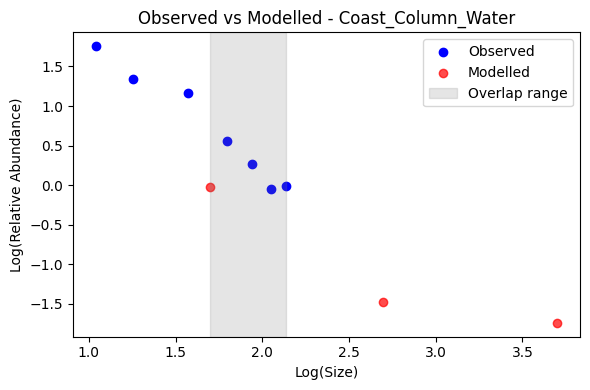

In [40]:
model_df=rel_abun
obs_df=obs_subset
plot_obs_vs_model(obs_df, model_df, comp)


In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp, art=art,
                                   x_col="log_size",x_obs_col="log_Size",
                                   y_obs_col="log_Abundance",
                                   y_mod_col="log_rel_abundance"):
    """
    Plot observed vs modeled log-abundance by size with regression and metrics.
    
    Parameters
    ----------
    obs_df : pd.DataFrame
        Observed dataset with columns x_col and y_obs_col
    model_df : pd.DataFrame
        Modeled dataset with columns x_col and y_mod_col
    compartment : str
        Name of the compartment for title
    art : str
        Name of the article for title
    """
    
    
    x_obs_all = obs_subset["log_Size"].astype(float).values
    y_obs_all = obs_subset["log_Abundance"].astype(float).values
    
    x_mod_all = filtered_Results["log_size"].values
    y_mod_all = filtered_Results["log_rel_abundance"].values
    
    # Fit powerlaw on observed dataset 
    if len(x_obs_all) >= 2:
        slope_obs, intercept_obs = np.polyfit(x_obs_all, y_obs_all, 1)
        x_fit_obs = np.linspace(x_obs_all.min(), x_obs_all.max(), 100)
        y_fit_obs = slope_obs * x_fit_obs + intercept_obs
        
        plt.figure(figsize=(8, 6))
        plt.scatter(x_obs_all, y_obs_all, color='blue', marker='o',
                    label=f"Observed: {art}")
        if x_fit_obs is not None:
            plt.plot(x_fit_obs, y_fit_obs, color='blue', linestyle='--',
                        label="_nolegend_")

    # Plot modelled dataset (filtered for excluded sizes)
    plt.scatter(x_mod_all, y_mod_all,marker='x', label=f"Model data: {comp}")
    slope_mod, intercept_mod = np.nan, np.nan
    if len(x_mod_all) >= 2:
        slope_mod, intercept_mod = np.polyfit(x_mod_all, y_mod_all, 1)
        x_fit_mod = np.linspace(x_mod_all.min(), x_mod_all.max(), 100)
        y_fit_mod = slope_mod*x_fit_mod + intercept_mod
        plt.plot(x_fit_mod, y_fit_mod, label="_nolegend_")

    # Compute metrics
    if len(x_obs_all) < 2 or len(x_mod_all) < 2:
        r2 = np.nan
        rmse = np.nan
        euclid_dist = np.nan
        n_points = 0
    else:
        # Intersection range
        x_min = max(x_obs_all.min(), x_mod_all.min())
        x_max = min(x_obs_all.max(), x_mod_all.max())
        mask_obs = (x_obs_all >= x_min) & (x_obs_all <= x_max)
        x_obs_filt = x_obs_all[mask_obs]
        y_obs_filt = y_obs_all[mask_obs]

        if len(x_obs_filt) < 2:
            r2 = np.nan
            rmse = np.nan
            n_points = len(x_obs_filt)
        else:
            pred_y = slope_mod*x_obs_filt + intercept_mod
            ss_res = np.sum((y_obs_filt - pred_y)**2)
            ss_tot = np.sum((y_obs_filt - y_obs_filt.mean())**2)
            r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
            rmse = np.sqrt(ss_res/len(x_obs_filt))
            n_points = len(x_obs_filt)

        if not np.isnan(slope_mod) and not np.isnan(slope_obs):
            euclid_dist = np.sqrt((slope_mod - slope_obs)**2 + (intercept_mod - intercept_obs)**2)
        else:
            euclid_dist = np.nan
    plt.xlabel("log(Size [µm])")
    plt.ylabel("log(Relative Abundance [%])")
    plt.title(f"Overlay: {art} - {comp}")
    # Annotate metrics
    plt.text(0.05, 0.95, f"RMSE = {rmse:.2f}\nR² = {r2:.2f}", transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    

In [89]:
def plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp, art=art):
    """ Plot observed vs modeled log-abundance by size with regression and metrics.
    
    Parameters
    ----------
    obs_df : pd.DataFrame
        Observed dataset with columns x_col and y_obs_col
    model_df : pd.DataFrame
        Modeled dataset with columns x_col and y_mod_col
    compartment : str
        Name of the compartment for title
    art : str
        Name of the article for title"""
    
    x_obs_all = obs_subset["log_Size"].astype(float).values
    y_obs_all = obs_subset["log_Abundance"].astype(float).values

    x_mod_all = filtered_Results["log_size"].values
    y_mod_all = filtered_Results["log_rel_abundance"].values

    # Fit powerlaw on observed dataset 
    if len(x_obs_all) >= 2:
        slope_obs, intercept_obs = np.polyfit(x_obs_all, y_obs_all, 1)
        x_fit_obs = np.linspace(x_obs_all.min(), x_obs_all.max(), 100)
        y_fit_obs = slope_obs * x_fit_obs + intercept_obs
        
        plt.figure(figsize=(8, 6))
        plt.scatter(x_obs_all, y_obs_all, color='blue', marker='o',
                    label=f"Observed: {art}")
        if x_fit_obs is not None:
            plt.plot(x_fit_obs, y_fit_obs, color='blue', linestyle='--',
                        label="_nolegend_")

    # Plot modelled dataset (filtered for excluded sizes)
    plt.scatter(x_mod_all, y_mod_all,marker='x', label=f"Model data: {comp}")
    slope_mod, intercept_mod = np.nan, np.nan
    if len(x_mod_all) >= 2:
        slope_mod, intercept_mod = np.polyfit(x_mod_all, y_mod_all, 1)
        x_fit_mod = np.linspace(x_mod_all.min(), x_mod_all.max(), 100)
        y_fit_mod = slope_mod*x_fit_mod + intercept_mod
        plt.plot(x_fit_mod, y_fit_mod, label="_nolegend_")

    # Compute metrics
    if len(x_obs_all) < 2 or len(x_mod_all) < 2:
        r2 = np.nan
        rmse = np.nan
        euclid_dist = np.nan
        n_points = 0
    else:
        # Intersection range
        x_min = max(x_obs_all.min(), x_mod_all.min())
        x_max = min(x_obs_all.max(), x_mod_all.max())
        mask_obs = (x_obs_all >= x_min) & (x_obs_all <= x_max)
        x_obs_filt = x_obs_all[mask_obs]
        y_obs_filt = y_obs_all[mask_obs]

        if len(x_obs_filt) < 2:
            r2 = np.nan
            rmse = np.nan
            n_points = len(x_obs_filt)
        else:
            pred_y = slope_mod*x_obs_filt + intercept_mod
            ss_res = np.sum((y_obs_filt - pred_y)**2)
            ss_tot = np.sum((y_obs_filt - y_obs_filt.mean())**2)
            r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
            rmse = np.sqrt(ss_res/len(x_obs_filt))
            n_points = len(x_obs_filt)

        if not np.isnan(slope_mod) and not np.isnan(slope_obs):
            euclid_dist = np.sqrt((slope_mod - slope_obs)**2 + (intercept_mod - intercept_obs)**2)
        else:
            euclid_dist = np.nan
    plt.xlabel("log(Size [µm])")
    plt.ylabel("log(Relative Abundance [%])")
    plt.title(f"Overlay: {art} - {comp}")
    # Annotate metrics
    plt.text(0.05, 0.95, f"RMSE = {rmse:.2f}\nR² = {r2:.2f}", transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    plt.legend()
    plt.grid(True)
    #plt.tight_layout()



In [47]:
plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp, art=art)

KeyError: 'log_size'

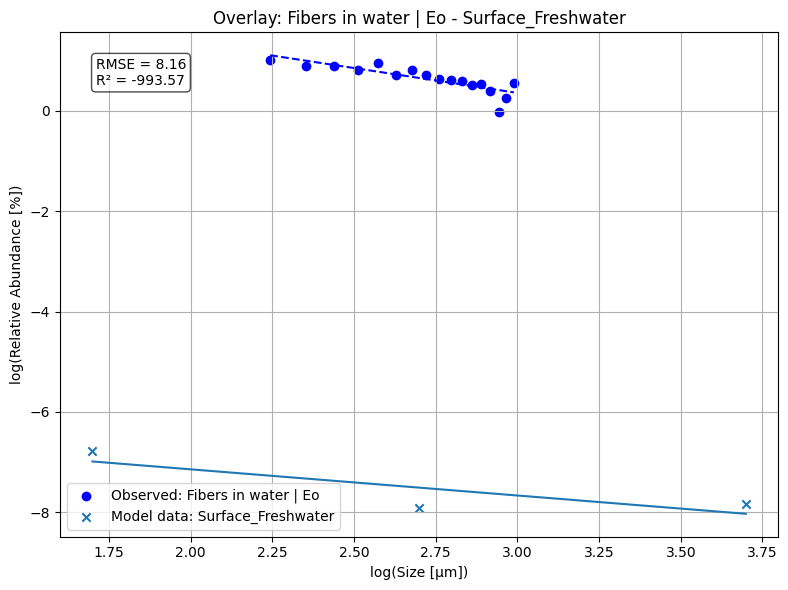

In [39]:
from utopia.utopia import utopiaModel
from utopia.results_processing.process_results import *
from utopia.monte_carlo.montecarlo_analysis_paper import *
observed_file = "../src/utopia/data/observed_data_long.xlsx"

observed_df = pd.read_excel(observed_file)

observed_df = observed_df.rename(
    columns={
        "dataset identifier": "Dataset",
        "Article name": "Article",
        "log‑transformed size": "log_Size",
        "log‑transformed abundance": "log_Abundance",
        }
    )

art= "Fibers in water | Eo"
comp_E = "Surface_Freshwater"
comp_T= "Surface_Freshwater"
data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp_E, "e", 100)
data_data["MPdensity_kg_m3"]= 900
data_data["FI"]= 0.3
data_data["t_half_deg_free"]= 36500
data_data["t_frag_gen_FreeSurfaceWater"]= 36
model = utopiaModel(config=config_data, data=data_data)
model.run()
processor = ResultsProcessor(model)
processor.estimate_flows()
processor.generate_flows_dict()
processor.process_results() 
processor.extract_results_by_compartment()
df = processor.results_by_comp
df2 = processor.Results_extended
processor.estimate_exposure_indicators()
model_df=df2.copy()
rel_abun = extract_log_rel_abundance(
    model_df,
    compartment=comp_T,
    value_col="number_of_particles",
)
excluded_sizes = [0.5, 5]
filtered_Results = rel_abun[
    ~rel_abun["Size_Fraction_um"].isin(excluded_sizes)
]
filtered_Results

obs_subset = observed_df[observed_df["Article"] == art]

plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=filtered_Results, compartment=comp_T, art=art)

In [ ]:
art= "Sea Surface Fibers | Song"
comp_E = "Ocean_Surface_Water"
comp_T= "Coast_Column_Water"
data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp_E, "e", 100)
data_data["MPdensity_kg_m3"]= 900
data_data["FI"]= 0.7
data_data["t_half_deg_free"]= 1000
data_data["t_frag_gen_FreeSurfaceWater"]= 31.6
model = utopiaModel(config=config_data, data=data_data)



c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


TypeError: plot_obs_vs_model_with_metrics() got an unexpected keyword argument 'input_dict'

In [ ]:
observed_file = "../src/utopia/data/observed_data_long.xlsx"

observed_df = pd.read_excel(observed_file)

observed_df = observed_df.rename(
    columns={
        "dataset identifier": "Dataset",
        "Article name": "Article",
        "log‑transformed size": "log_Size",
        "log‑transformed abundance": "log_Abundance",
        }
    )
for i in range(len(top_results)):
    art = top_results.iloc[i]["Observed_dataset"]
    comp_E = top_results.iloc[i]["Emission_Compartment"]
    comp_T= top_results.iloc[i]["Target_Compartment"]
    data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp_E, "e", 100)
    data_data["MPdensity_kg_m3"]= top_results.iloc[i]["MPdensity_kg_m3"]
    data_data["FI"]= top_results.iloc[i]["FI"]
    data_data["t_half_deg_free"]= top_results.iloc[i]["t_half_deg_free"]
    data_data["t_frag_gen_FreeSurfaceWater"]= top_results.iloc[i]["t_frag_gen_FreeSurfaceWater"]
    model = utopiaModel(config=config_data, data=data_data)
    model.run()
    processor = ResultsProcessor(model)
    processor.estimate_flows()
    processor.generate_flows_dict()
    processor.process_results() 
    processor.extract_results_by_compartment()
    df = processor.results_by_comp
    df2 = processor.Results_extended
    processor.estimate_exposure_indicators()
    model_df=df2.copy()
    excluded_sizes = [0.5, 5]
    filtered_Results = model_df[
        ~model_df["Size_Fraction_um"].isin(excluded_sizes)
    ]
    rel_abun = extract_log_rel_abundance(
        filtered_Results,
        compartment=comp,
        value_col="number_of_particles",
)
    
    input_dict={"MPdensity_kg_m3":data_data["MPdensity_kg_m3"],"FI":data_data["FI"],"t_half_deg_free":data_data["t_half_deg_free"],"t_frag_gen_FreeSurfaceWater":data_data["t_frag_gen_FreeSurfaceWater"]}
        
        obs_subset = observed_df[observed_df["Article"] == art]
        
        plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp_T, art=art,input_dict=input_dict)